# Libraries

In [1]:
import psutil
psutil.virtual_memory() 

svmem(total=540408942592, available=524733153280, percent=2.9, used=12320956416, free=526113873920, active=750264320, inactive=4028514304, buffers=4354048, cached=1969758208, shared=236580864, slab=1622159360)

In [2]:
from datetime import datetime

import numpy as np
import pandas as pd
from numpy import array

from os import listdir
from os.path import isfile, join
import glob

import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#import cmocean
##from mpl_toolkits.basemap import Basemap

from matplotlib import ticker
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from cartopy.mpl.ticker import LongitudeFormatter


import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
import scipy as _sp

In [3]:
import klus.algorithms as al
# import d3s.domain as domain
import klus.kernels as kernels
# import d3s.tools as tools

import zapata.computation as zcom
import zapata.data as zdat
import zapata.lib as zlib
import zapata.mapping as zmap
import zapata.koopman as zkop

from scipy.spatial import distance

from scipy.signal import argrelextrema
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

#%pdb
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import scipy.linalg as sc
import numpy.linalg as lin

# Definition of functions

## Definition order_w

In [5]:
def order_w(w,option='magnitude',direction='up'):
    '''
    Order Eigenvalues according to 
    option
    'magnitude'         abs(w)
    'frequency'         w.imag
    'growth'            w.real
    'ones'              abs(w) closest to 1.0
    
    direction
    'up'               descending
    'down'             ascending
    
    '''
    print(' Ordering Eigenvalues as ', option, ' with direction ',direction)
    w_cont = np.log(w)
    if option == 'magnitude':
        ind=abs(w).argsort()
    elif option == 'frequency':
        ind=abs(w_cont.imag).argsort()
    elif option == 'growth':
        ind=np.abs(w_cont.real - 0.0).argsort()
    elif option == 'one':
        ind=np.abs(np.abs(w) - 1.0).argsort()
    else:
        print(' Error in oder_w', option, direction)
# Choose direction
    if direction == 'up':
        indu=ind[::-1]
    else:
        indu=ind

    w0=w[indu]
    w1=w_cont[indu]
    return w0,w1,indu


## Definition function evolve and verify

In [6]:
def evolve(tim_level,tstep,init_date):
    #tim_level=[0,1,2,3,4,5,6]
    #cases =  216,228,240, 36,48,60,  360,372,384
    #tstep=3
    #nstart=360
    x0=PsiX[:,init_date]
    ht=np.zeros([x0.shape[0],len(tim_level)],dtype='complex')
    for j in tim_level:
        D = np.diag(vw_s[:nmode]**(j*tstep))                  # w --> vw_s
        ht[:,j]=alpha@D@vcut.T@Gxx[init_date,:] 
    return ht

#verify to EOF expansion  (spatial correlation)
def verify(tim_level,tstep,init_date,PCs,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        kaz2=PCs[:,int(init_date+neig*tstep)]
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz2, axis=1)
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp[:,0])[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab


#verify to total data
def verify_tot(tim_level,tstep,init_date,X,ht,verbose=False):
    sstcor=np.zeros([len(tim_level)])
    sstlab=np.zeros([len(tim_level)],dtype='int')
    for neig in range(len(tim_level)):
        kaz1=ht[:,neig].real 
        ytmp = np.expand_dims(udat_tot[:,0:nEOF_SST]@kaz1, axis=1)
        ztmp = X.A.data[:, int(init_date+neig*tstep)]
        #ICcase=lib.year2date(years,nstart)
        #ICdat=lib.year2date(years,tstep*neig+nstart)
        #label1 = ' at {}, IC at {}'.format(ICdat,ICcase)
        val=np.corrcoef(ytmp[:,0],ztmp)[0,1]
        if verbose : print(' Correlation at {}    {}'.format(label1,val))
        sstcor[neig]=val
        sstlab[neig]=int(tstep*neig+init_date)
    return sstcor,sstlab

## Definition dates2years

In [7]:
def date2year(years,init_year,date):
    """Transform index date ['Jan' '1989' ] in index i.
    
    Years are from np.arange(1960,2020, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=float(date[4:8])
    m=mon.index(str(date[0:3]))
    index = (y-init_year)*12 + m
    return int(index)

In [8]:
def year2date(years,i):
    """ Transform index i in string date yy/mm.
    
    Rounding requires the small shift
    Years are obtained from np.arange(1920,2018, 1/12)
    """
    mon=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
    y=str(int(years[i]+0.001))
    m=np.mod(int(round((years[i]-int(years[i]))*12)),12)
    date = mon[m] + ' ' + y
    return date

## Definition eigenvalues on points

In [9]:
def eigenfunction_value(cc, KK_tot, x, mode ):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    f = 0
    for i in range(KK_tot.ntime):
        f +=  cc[i,mode]*k(x, KK_tot.PsiX[:, i])       #somma per tutti i tempo: componente del modo (colonna) per kernel(initial condition x, fila PsiX)
    return f

In [10]:
def eigenfunction_value_opt(cc, KK_tot, x, mode):
    '''
    Compute eigenfunction value at point x

    Parameters
    ----------
    x: Point at which eigenfunction is computed
    mode: Mode number

    Returns
    -------
    eigenfunction value
    '''
    k = KK_tot.ker
    ntime = KK_tot.ntime
    PsiX = KK_tot.PsiX
    mode_cc = cc[:, mode]  # Extract the mode component once

    # Precompute k(x, PsiX) to avoid redundant calculations
    k_values = np.array([k(x, PsiX[:, i]) for i in range(ntime)])

    f = np.dot(mode_cc, k_values)  # Use NumPy dot product for summation
    return f

## Definition sigma cost function

In [11]:
from scipy.optimize import minimize_scalar

In [12]:
def cost(x):
    ss = str(x)
    KK_tot.fit(bandwidth=ss)
    KMM = sc.pinv(KK_tot.vv)@(KK_tot.PsiX.T)
    return sum(lin.norm(KK_tot.vv@KMM-KK_tot.PsiX.T, axis=0))

# Load and regrid data

In [6]:
#CMIP Jakob
ds_tos = xr.open_dataarray("CESM_data/regridded_tos.nc")
ds_ssh = xr.open_dataarray("CESM_data/regridded_ssh.nc")

In [7]:
ds_tos

<xarray.DataArray (time: 24000, lat: 180, lon: 360)>
[1555200000 values with dtype=float32]
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 2001-01-01 00:00:00
    z_t      float32 ...
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
Attributes:
    regrid_method:  bilinear

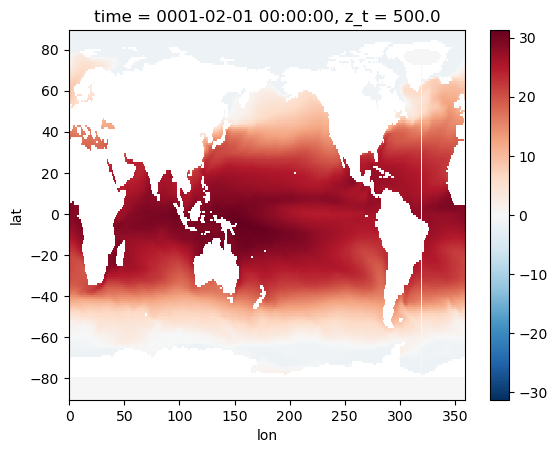

In [8]:
ds_tos.isel(time=0).plot()

## Subset data

In [9]:
#  Read Variable
area='Jakob'
if area == 'TROPIC':
    # central pacific coordinates
    arealat=(35,-35)
    arealon=[-180, 180.]
elif area == 'GLOBAL':
    arealat=(60,-60)
    arealon=[-160,110.]
elif area == 'WORLD':
    arealat=(60,-60)
    arealon=[-180,180.]
elif area == 'NAVARRA_2021':
    arealat=(-15,15)
    arealon=[140,290.]
elif area == 'Jakob':
    arealat=(-31,32)
    arealon=[130,290.]
else:
    Print(f'No area ')
    
case = 'UNIT'    
data_name= 'CESM'
variable='SST'
lev = 'SURF'
shift = 'ERA5'
period = 'ANN'
normalization = 'anom'

# Use SVD encoding
encode_svd = True
#Choose number of SVD to ratain
var_retained = None #None# Variance retained or None for full rank
#Option to write files
write_files = False

In [10]:
S_tos = ds_tos.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))
S_ssh = ds_ssh.sel(lat=slice(arealat[0],arealat[1]),lon=slice(arealon[0],arealon[1]))

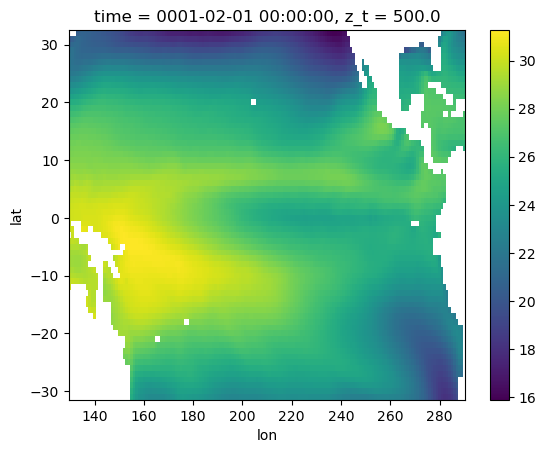

In [11]:
S_tos.isel(time=0).plot()

In [12]:
del(ds_tos, ds_ssh)

In [13]:
import psutil
psutil.virtual_memory() 

svmem(total=540408942592, available=524452536320, percent=3.0, used=12567945216, free=525799628800, active=815079424, inactive=4277288960, buffers=4354048, cached=2037014528, shared=236580864, slab=1623179264)

## Create matrices, de-trending data and anomalies

In [14]:
#Create Xmats
X_tos=zcom.Xmat(S_tos,dims=('lat','lon'))
X_tos.A = X_tos.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [15]:
X_ssh=zcom.Xmat(S_ssh,dims=('lat','lon'))
X_ssh.A = X_ssh.A.dropna(dim='z')

 Created mathematical matrix A, 
                 stacked along dimensions ('lat', 'lon') 


In [16]:
del(S_tos,S_ssh)

In [17]:
#Detrending
X_tos.detrend(axis=1)
X_ssh.detrend(axis=1)

Detrending data with options -->  {'axis': 1}
Detrending data with options -->  {'axis': 1}


In [18]:
#Anomalies
X_tos.anom(option='anomstd',freq='month')
X_ssh.anom(option='anomstd',freq='month')

In [19]:
del(X_ssh)

# Evaluation

### Tools for the plots

In [20]:
import nc_time_axis

In [21]:
flabel = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':18,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [22]:
from pylab import *

cmap = cm.get_cmap('plasma', 19)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

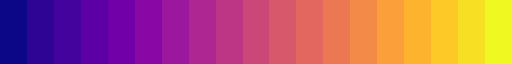

In [23]:
cmap   # First forecasts purple,    last forecasts yellow

### Data preparation

In [24]:
## Load EOFs
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [25]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
operators=[0,1,2,3]
periods=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
lead_times=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]

# Non overlapping overall graph

In [33]:
Poly_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_1000.npy')
Gauss30_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_1000.npy')
GaussALL_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_1000.npy')

Poly_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_1000.npy')
Gauss30_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_1000.npy')
GaussALL_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_1000.npy')

In [34]:
Poly_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_400.npy')
Gauss30_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_400.npy')
GaussALL_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_400.npy')

Poly_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_400.npy')
Gauss30_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_400.npy')
GaussALL_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_400.npy')

In [35]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [36]:
Poly_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [37]:
Poly_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

In [38]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

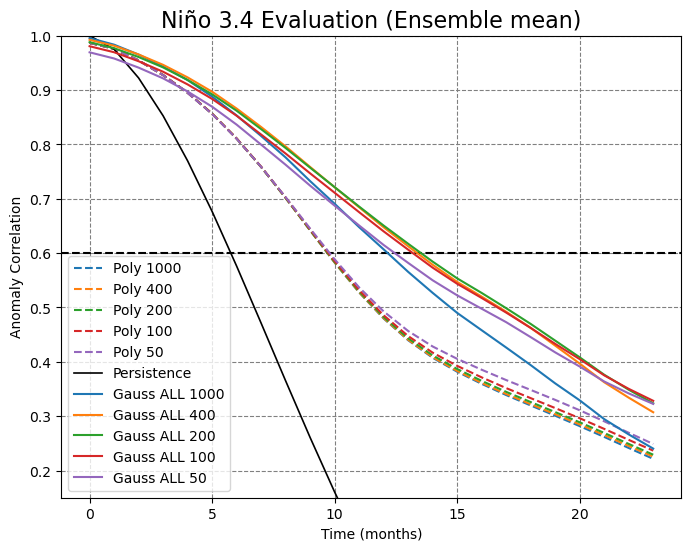

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,24)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Anomaly Correlation')
ax.set_ylim([0.15,1])
ax.set_title('',loc='left')

ax.plot(xval, Poly_mean_1000, lw=1.5, label='Poly 1000', linestyle='dashed')
ax.plot(xval, Poly_mean_400, lw=1.5, label='Poly 400', linestyle='dashed')
ax.plot(xval, Poly_mean_200, lw=1.5, label='Poly 200', linestyle='dashed')
ax.plot(xval, Poly_mean_100, lw=1.5, label='Poly 100', linestyle='dashed')
ax.plot(xval, Poly_mean_50, lw=1.5, label='Poly 50', linestyle='dashed')


ax.plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

plt.gca().set_prop_cycle(None)

ax.plot(xval, GaussALL_mean_1000, lw=1.5, label='Gauss ALL 1000')
ax.plot(xval, GaussALL_mean_400, lw=1.5, label='Gauss ALL 400')
ax.plot(xval, GaussALL_mean_200, lw=1.5, label='Gauss ALL 200')
ax.plot(xval, GaussALL_mean_100, lw=1.5, label='Gauss ALL 100')
ax.plot(xval, GaussALL_mean_50, lw=1.5, label='Gauss ALL 50')


bigtitle = 'Niño 3.4 Evaluation (Ensemble mean)' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

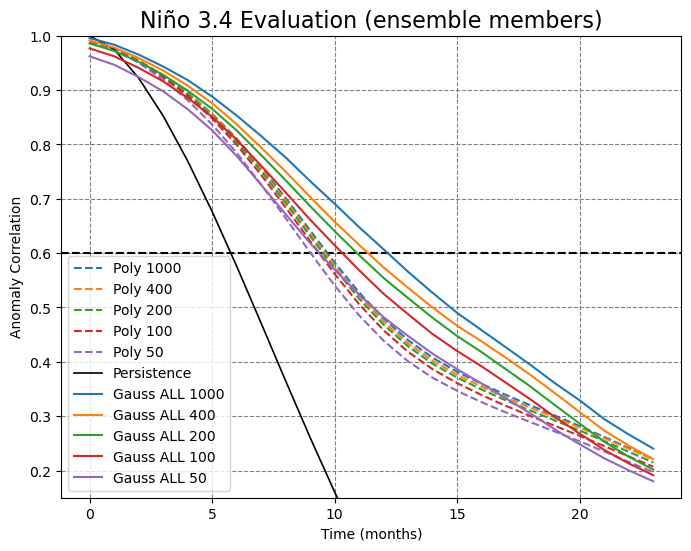

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,6))

xval=range(0,24)

ax.axhline(0.6, linestyle='--',color='black')
ax.set_xlabel('Time (months)')
ax.set_ylabel('Anomaly Correlation')
ax.set_ylim([0.15,1.0])
ax.set_title('',loc='left')

ax.plot(xval, np.mean(Poly_ind_1000, axis=1), lw=1.5, label='Poly 1000', linestyle='dashed')
ax.plot(xval, np.mean(Poly_ind_400, axis=1), lw=1.5, label='Poly 400', linestyle='dashed')
ax.plot(xval, np.mean(Poly_ind_200, axis=1), lw=1.5, label='Poly 200', linestyle='dashed')
ax.plot(xval, np.mean(Poly_ind_100, axis=1), lw=1.5, label='Poly 100', linestyle='dashed')
ax.plot(xval, np.mean(Poly_ind_50, axis=1), lw=1.5, label='Poly 50', linestyle='dashed')


ax.plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

plt.gca().set_prop_cycle(None)

ax.plot(xval, np.mean(GaussALL_ind_1000, axis=1), lw=1.5, label='Gauss ALL 1000')
ax.plot(xval, np.mean(GaussALL_ind_400, axis=1), lw=1.5, label='Gauss ALL 400')
ax.plot(xval, np.mean(GaussALL_ind_200, axis=1), lw=1.5, label='Gauss ALL 200')
ax.plot(xval, np.mean(GaussALL_ind_100, axis=1), lw=1.5, label='Gauss ALL 100')
ax.plot(xval, np.mean(GaussALL_ind_50, axis=1), lw=1.5, label='Gauss ALL 50')


bigtitle = 'Niño 3.4 Evaluation (ensemble members)' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.legend()
plt.suptitle('',fontsize='xx-large')
labfile = 'due metodi forecasting MONTHS' + '.pdf'
#plt.savefig(labfile, orientation='landscape',  format='pdf')
plt.show() 

# Old Fig 3

In [33]:
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [34]:
tot_for=np.load('Forecasts 100/ALLEOFs_forecast_p0.npy')

In [35]:
tot_for[:,0,0,0]

array([ 7.73776497,  6.37298595,  9.07247107,  7.04164967,  8.24139628,
        8.18895905,  7.34830378,  6.58008304,  6.2975239 ,  6.9611809 ,
        9.06840809, 10.29774223,  6.43367604,  7.13646685,  7.50188595,
        7.61376415,  7.89305517,  4.97931238,  5.51516557])

In [36]:
flabel = {'fontsize':12,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura',

## Leads extended

In [86]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
lead_times=[0,5,10,15,20]

In [87]:
mean_av=np.zeros(24)
mean_ind=np.zeros((24,19))

In [88]:
Jrmse_mean_av=np.zeros(24)
Jrmse_mean_ind=np.zeros((24,19))

In [89]:
#Select period
m=0
X_tos_sel=X_tos.A[:,m*1200:1200+m*1200]

In [90]:
## Compute observations NON truncated to PCs
Xindex=X_tos_sel.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))[:-1]
Xindex

<xarray.DataArray (time: 1199)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.275772  ,
       -0.23491153, -0.30251884], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0100-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11 12

0.9800231061297353
0.9761812708353775
0.8688439550699649
0.8347016228570155
0.6749347760119037
0.5791986504599403
0.44557779787199314
0.3441290718829845
0.2792564070782694
0.1878965961764422
0.9879465948670371
0.9879465948670368
0.8480913355353769
0.8394207685930428
0.5789093999179046
0.5570456022001026
0.3637862895525416
0.33737507045116155
0.22868124652965968
0.20384534926388864


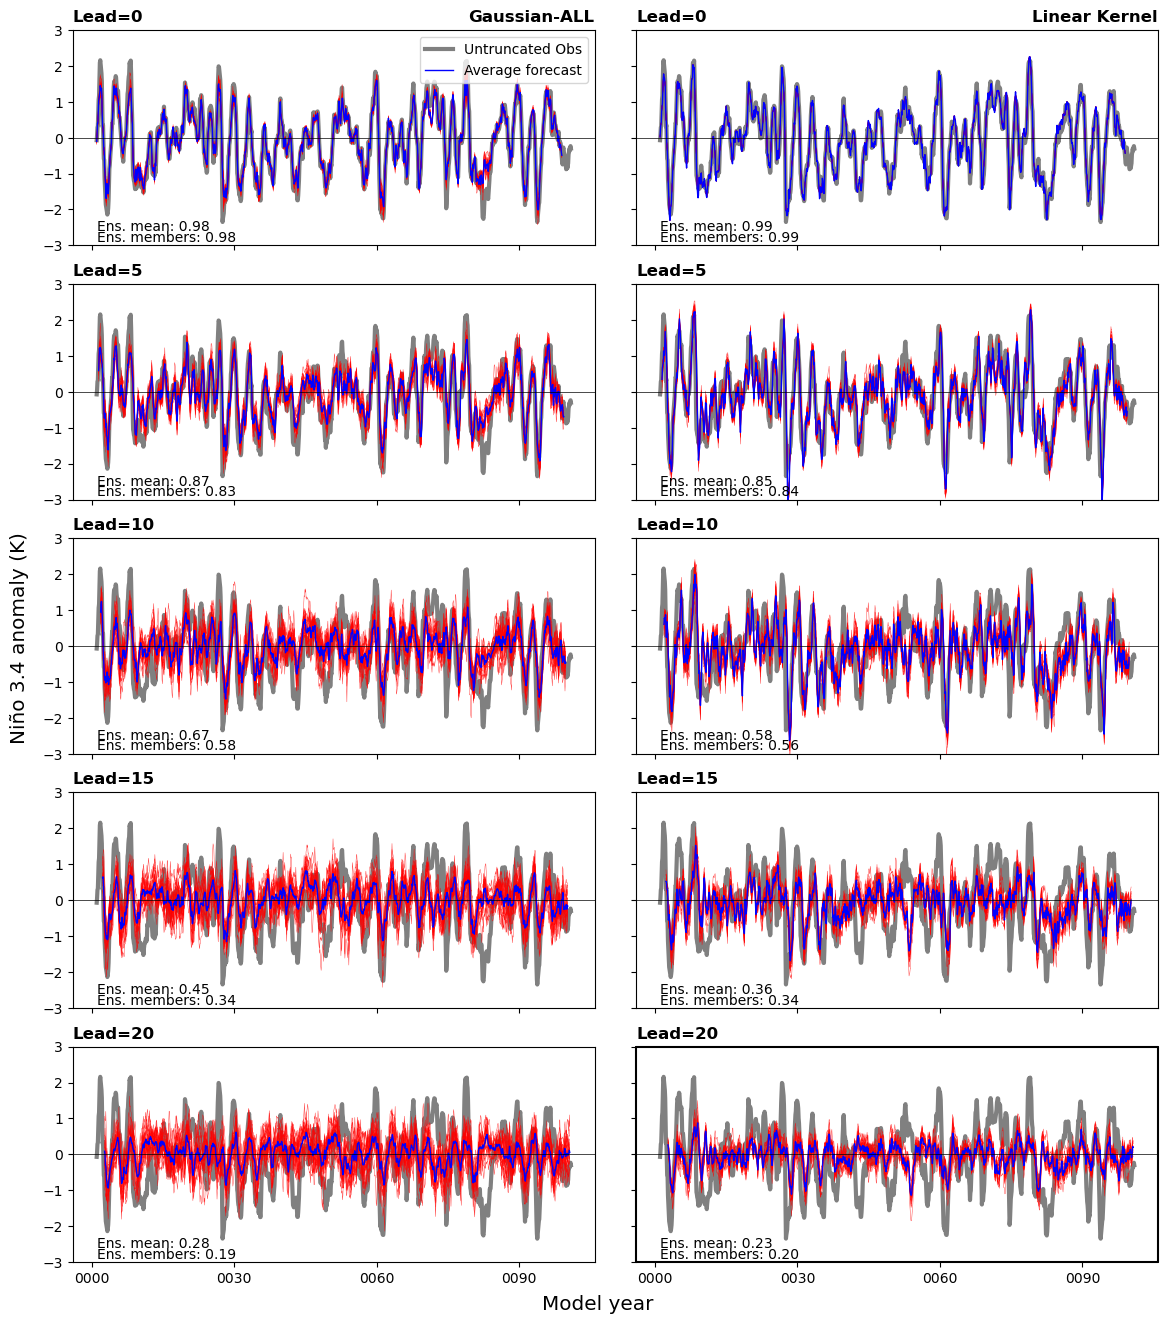

In [91]:
columns = 2
rows = 5

fig, axs = plt.subplots(rows, columns,figsize=(14,16),sharey=True,sharex=True)

##################################################################
#############          GAUSS                ######################
##################################################################


PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')
tot_for=np.load('Forecasts 100/ALLEOFs_forecast_p0.npy')
udat_sst=EOFs[:,0:845]

for n in range(len(lead_times)):

    lead=lead_times[n]

    ## Compute average forecast
    av_for=np.mean(tot_for, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
    av_for_geo.data=av_for_geo_array.real
    Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Correlation average forecast and observations
    mean_av[lead]=np.corrcoef(Xindex[0+lead:1176+lead],Avindex)[0,1]
    print(mean_av[lead])

    #Average correlation between individual forecast and observations
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        mean_ind[lead,i]=np.corrcoef(Xindex[0+lead:1176+lead],Phiindex)[0,1]

    av_corr=np.mean(mean_ind, axis=1)[lead]
    print(av_corr)
        
    ###### Plot
    import nc_time_axis

    if n==0:
        Xindex.plot(ax=axs[n,0],label='Untruncated Obs',lw=3,color='gray')
    else:
        Xindex.plot(ax=axs[n,0],lw=3,color='gray')

    for i in for_levels:  
        #Expand forecast to geographical domain
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real

        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        Phiindex.plot(ax=axs[n,0],lw=0.3, color='red', alpha=0.8)

    if n==0:
        Avindex.plot(ax=axs[n,0],label='Average forecast',lw=1,color='blue')
        axs[n,0].legend(loc='upper right')
    else:
        Avindex.plot(ax=axs[n,0],lw=1,color='blue')
    
    axs[n,0].axhline(0,color='black',lw=0.5)

    if n==0:
        axs[n,0].set_title(f'Gaussian-ALL',loc='right',**flabel)
        
    axs[n,0].set_title(f'Lead={lead_times[n]}',loc='Left',**flabel)
    
    axs[n,0].set_title(f'',loc='center',**flabel)
    zmap.changebox(plt.gca(),'all',linewidth=1.5)
    cstr1 = f'Ens. mean: {mean_av[lead]:>.2f}'
    cstr2 = f'Ens. members: {av_corr:>.2f}'
    #loctime = Xindex.isel(time=338).time.data
    loctime = Xindex.isel(time=0).time.data
    axs[n,0].text(loctime,-2.6,cstr1)
    axs[n,0].text(loctime,-2.9,cstr2)
    axs[n,0].set_ylim(-3,3)
    axs[n,0].set_xlabel('')


##################################################################
#############          POLY                ######################
##################################################################

PCs=np.load('Processed_data/PCs_CESM_20SST_10SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_20SST_10SSH.npy')
tot_for=np.load('Forecasts 100/Poly_forecast_p0.npy')
udat_sst=EOFs[:,0:20]


for n in range(len(lead_times)):

    lead=lead_times[n]

    ## Compute average forecast
    av_for=np.mean(tot_for, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
    av_for_geo.data=av_for_geo_array.real
    Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Correlation average forecast and observations
    mean_av[lead]=np.corrcoef(Xindex[0+lead:1176+lead],Avindex)[0,1]
    print(mean_av[lead])

    #Average correlation between individual forecast and observations
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        mean_ind[lead,i]=np.corrcoef(Xindex[0+lead:1176+lead],Phiindex)[0,1]

    av_corr=np.mean(mean_ind, axis=1)[lead]
    print(av_corr)
        
    ###### Plot
    import nc_time_axis

    Xindex.plot(ax=axs[n,1],lw=3,color='gray')
           
    for i in for_levels:  
        #Expand forecast to geographical domain
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real

        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        Phiindex.plot(ax=axs[n,1],lw=0.3, color='red', alpha=0.8)

    Avindex.plot(ax=axs[n,1],lw=1,color='blue')

    axs[n,1].axhline(0,color='black',lw=0.5)
    
    if n==0:
        axs[n,1].set_title(f'Linear Kernel',loc='right',**flabel)
    
    axs[n,1].set_title(f'Lead={lead_times[n]}',loc='left',**flabel)
        
    axs[n,1].set_title(f'',loc='center',**flabel)
    zmap.changebox(plt.gca(),'all',linewidth=1.5)
    cstr1 = f'Ens. mean: {mean_av[lead]:>.2f}'
    cstr2 = f'Ens. members: {av_corr:>.2f}'
    axs[n,1].text(loctime,-2.6,cstr1)
    axs[n,1].text(loctime,-2.9,cstr2)
    axs[n,1].set_ylim(-3,3)
    axs[n,1].set_xlabel('')

fig.text(0.5, 0.08, 'Model year', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Niño 3.4 anomaly (K)', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.08, hspace=0.18)
plt.savefig(f'Fig 3.pdf', orientation='landscape',  format='pdf')
plt.savefig(f'Fig 3.jpg', orientation='landscape',  format='jpg')

plt.show()


## Leads

In [48]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
lead_times=[0,6,12,18]

In [49]:
mean_av=np.zeros(24)
mean_ind=np.zeros((24,19))

In [50]:
Jrmse_mean_av=np.zeros(24)
Jrmse_mean_ind=np.zeros((24,19))

In [51]:
#Select period
m=0
X_tos_sel=X_tos.A[:,m*1200:1200+m*1200]

In [52]:
## Compute observations NON truncated to PCs
Xindex=X_tos_sel.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))[:-1]
Xindex

<xarray.DataArray (time: 1199)>
array([-0.07060546,  0.05650981,  0.28544343, ..., -0.275772  ,
       -0.23491153, -0.30251884], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0100-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11 12

0.9800231061297353
0.9761812708353775
0.8350903536794104
0.789491312666101
0.5846871507352477
0.4765406215338124
0.3463692930078995
0.2500636576694914
0.9879465948670371
0.9879465948670368
0.8011016021146725
0.7895163082748177
0.47732998288954437
0.4526712647707456
0.2798136338076773
0.25370149906332484


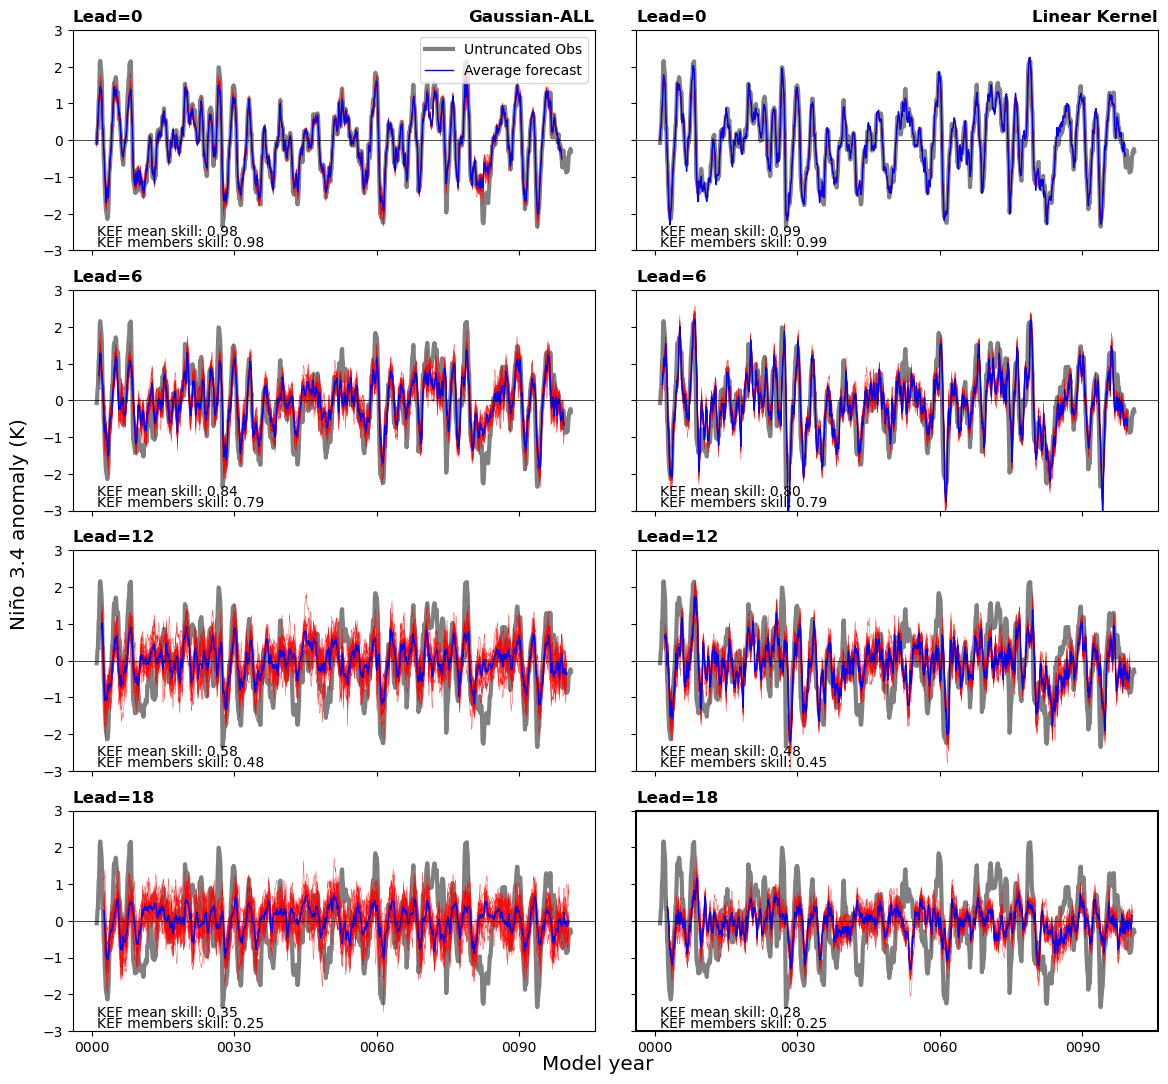

In [53]:
columns = 2
rows = 4

fig, axs = plt.subplots(rows, columns,figsize=(14,13),sharey=True,sharex=True)

##################################################################
#############          GAUSS                ######################
##################################################################


PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')
tot_for=np.load('Forecasts 100/ALLEOFs_forecast_p0.npy')
udat_sst=EOFs[:,0:845]

for n in range(len(lead_times)):

    lead=lead_times[n]

    ## Compute average forecast
    av_for=np.mean(tot_for, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
    av_for_geo.data=av_for_geo_array.real
    Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Correlation average forecast and observations
    mean_av[lead]=np.corrcoef(Xindex[0+lead:1176+lead],Avindex)[0,1]
    print(mean_av[lead])

    #Average correlation between individual forecast and observations
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        mean_ind[lead,i]=np.corrcoef(Xindex[0+lead:1176+lead],Phiindex)[0,1]

    av_corr=np.mean(mean_ind, axis=1)[lead]
    print(av_corr)
        
    ###### Plot
    import nc_time_axis

    if n==0:
        Xindex.plot(ax=axs[n,0],label='Untruncated Obs',lw=3,color='gray')
    else:
        Xindex.plot(ax=axs[n,0],lw=3,color='gray')

    for i in for_levels:  
        #Expand forecast to geographical domain
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real

        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        Phiindex.plot(ax=axs[n,0],lw=0.3, color='red', alpha=0.8)

    if n==0:
        Avindex.plot(ax=axs[n,0],label='Average forecast',lw=1,color='blue')
        axs[n,0].legend(loc='upper right')
    else:
        Avindex.plot(ax=axs[n,0],lw=1,color='blue')
    
    axs[n,0].axhline(0,color='black',lw=0.5)

    if n==0:
        axs[n,0].set_title(f'Gaussian-ALL',loc='right',**flabel)
        
    axs[n,0].set_title(f'Lead={lead_times[n]}',loc='Left',**flabel)
    
    axs[n,0].set_title(f'',loc='center',**flabel)
    zmap.changebox(plt.gca(),'all',linewidth=1.5)
    cstr1 = f'KEF mean skill: {mean_av[lead]:>.2f}'
    cstr2 = f'KEF members skill: {av_corr:>.2f}'
    #loctime = Xindex.isel(time=338).time.data
    loctime = Xindex.isel(time=0).time.data
    axs[n,0].text(loctime,-2.6,cstr1)
    axs[n,0].text(loctime,-2.9,cstr2)
    axs[n,0].set_ylim(-3,3)
    axs[n,0].set_xlabel('')


##################################################################
#############          POLY                ######################
##################################################################

PCs=np.load('Processed_data/PCs_CESM_20SST_10SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_20SST_10SSH.npy')
tot_for=np.load('Forecasts 100/Poly_forecast_p0.npy')
udat_sst=EOFs[:,0:20]


for n in range(len(lead_times)):

    lead=lead_times[n]

    ## Compute average forecast
    av_for=np.mean(tot_for, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
    av_for_geo.data=av_for_geo_array.real
    Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Correlation average forecast and observations
    mean_av[lead]=np.corrcoef(Xindex[0+lead:1176+lead],Avindex)[0,1]
    print(mean_av[lead])

    #Average correlation between individual forecast and observations
    for i in range(19):  
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        mean_ind[lead,i]=np.corrcoef(Xindex[0+lead:1176+lead],Phiindex)[0,1]

    av_corr=np.mean(mean_ind, axis=1)[lead]
    print(av_corr)
        
    ###### Plot
    import nc_time_axis

    Xindex.plot(ax=axs[n,1],lw=3,color='gray')
           
    for i in for_levels:  
        #Expand forecast to geographical domain
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real

        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        Phiindex.plot(ax=axs[n,1],lw=0.3, color='red', alpha=0.8)

    Avindex.plot(ax=axs[n,1],lw=1,color='blue')

    axs[n,1].axhline(0,color='black',lw=0.5)
    
    if n==0:
        axs[n,1].set_title(f'Linear Kernel',loc='right',**flabel)
    
    axs[n,1].set_title(f'Lead={lead_times[n]}',loc='left',**flabel)
        
    axs[n,1].set_title(f'',loc='center',**flabel)
    zmap.changebox(plt.gca(),'all',linewidth=1.5)
    cstr1 = f'KEF mean skill: {mean_av[lead]:>.2f}'
    cstr2 = f'KEF members skill: {av_corr:>.2f}'
    axs[n,1].text(loctime,-2.6,cstr1)
    axs[n,1].text(loctime,-2.9,cstr2)
    axs[n,1].set_ylim(-3,3)
    axs[n,1].set_xlabel('')

fig.text(0.5, 0.08, 'Model year', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Niño 3.4 anomaly (K)', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.08, hspace=0.18)
plt.savefig(f'Fig 3.pdf', orientation='landscape',  format='pdf')
plt.savefig(f'Fig 3.jpg', orientation='landscape',  format='jpg')

plt.show()


# New Fig 3 (200K)

In [37]:
PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')

In [50]:
tot_for=np.load('Forecasts 200/ALLEOFs_forecast_p0.npy')

In [51]:
tot_for.shape

(17, 1845, 24, 1176)

In [52]:
tot_for[:,0,0,0]

array([ 7.91518737,  9.47315223,  8.0932909 , 10.1130025 ,  7.33820015,
        6.57110234,  7.43062048,  6.74100564,  7.20900213,  9.66113676,
        8.01621466,  7.98938938,  7.40238941,  6.54756462,  7.02361842,
        6.64133949,  5.83434364])

In [53]:
flabel = {'fontsize':12,'fontweight':'bold'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':14,'fontweight':'bold'}   #,'fontfamily':'Futura',

In [55]:
tot_for=tot_for[[0,2,4,6,8,10,12,14,16],:,:,:]

## Leads

In [56]:
for_levels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
lead_times=[0,6,12,18]

In [57]:
mean_av=np.zeros(24)
mean_ind=np.zeros((24,9))

In [58]:
Jrmse_mean_av=np.zeros(24)
Jrmse_mean_ind=np.zeros((24,9))

In [59]:
#Select period
m=0
X_tos_sel=X_tos.A[:,m*1200:1200+m*1200]

In [60]:
## Compute observations NON truncated to PCs
Xindex=X_tos_sel.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))[:-1]
Xindex

<xarray.DataArray (time: 1199)>
array([-0.07060368,  0.05651168,  0.28544566, ..., -0.27576983,
       -0.23490955, -0.3025171 ], dtype=float32)
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0100-12-01 00:00:00
    z_t      float32 500.0
    month    (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11 12

0.9870811639511884
0.9850778782554153
0.846339014291934
0.8093684947450869
0.600736632306426
0.5034901351194979
0.36921063392531617
0.2781585196160727
0.9879465926429853
0.9879465926429855
0.8022475850436813
0.7958726876408384
0.4774186301281405
0.4637301553259285
0.2770594053130963
0.26424560921699136


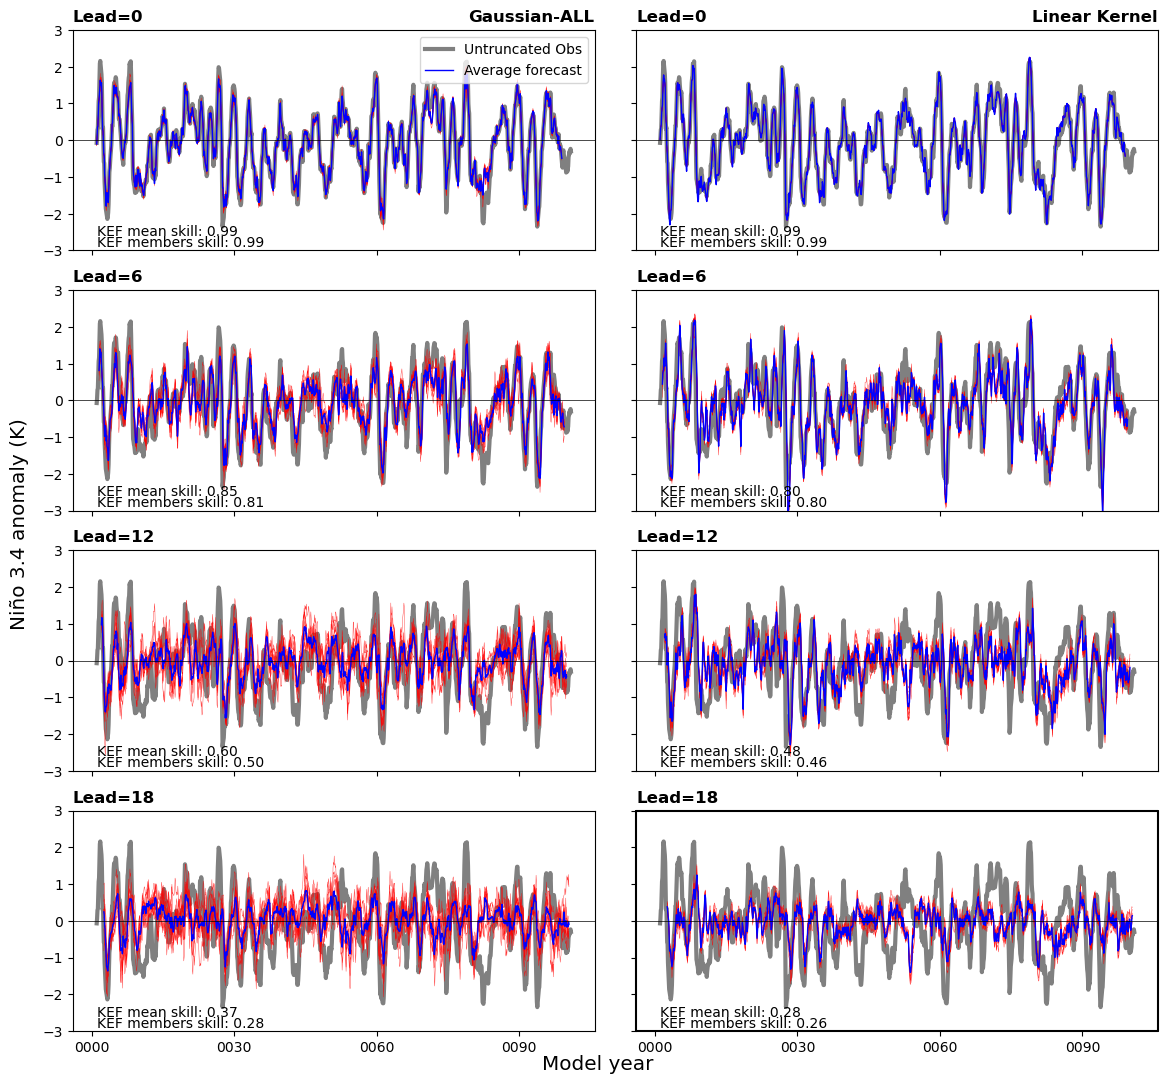

In [64]:
columns = 2
rows = 4

fig, axs = plt.subplots(rows, columns,figsize=(14,13),sharey=True,sharex=True)

##################################################################
#############          GAUSS                ######################
##################################################################


PCs=np.load('Processed_data/PCs_CESM_845SST_1000SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_845SST_1000SSH.npy')
tot_for=np.load('Forecasts 200/ALLEOFs_forecast_p0.npy')
tot_for=tot_for[[0,2,4,6,8,10,12,14,16],:,:,:]
udat_sst=EOFs[:,0:845]

for n in range(len(lead_times)):

    lead=lead_times[n]

    ## Compute average forecast
    av_for=np.mean(tot_for, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:845,lead,:]            
    av_for_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
    av_for_geo.data=av_for_geo_array.real
    Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Correlation average forecast and observations
    mean_av[lead]=np.corrcoef(Xindex[0+lead:1176+lead],Avindex)[0,1]
    print(mean_av[lead])

    #Average correlation between individual forecast and observations
    for i in range(9):  
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        mean_ind[lead,i]=np.corrcoef(Xindex[0+lead:1176+lead],Phiindex)[0,1]

    av_corr=np.mean(mean_ind, axis=1)[lead]
    print(av_corr)
        
    ###### Plot
    import nc_time_axis

    if n==0:
        Xindex.plot(ax=axs[n,0],label='Untruncated Obs',lw=3,color='gray')
    else:
        Xindex.plot(ax=axs[n,0],lw=3,color='gray')

    for i in range(9):  
        #Expand forecast to geographical domain
        phix_geo_array=udat_sst @ tot_for[i,0:845,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real

        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        Phiindex.plot(ax=axs[n,0],lw=0.3, color='red', alpha=0.8)

    if n==0:
        Avindex.plot(ax=axs[n,0],label='Average forecast',lw=1,color='blue')
        axs[n,0].legend(loc='upper right')
    else:
        Avindex.plot(ax=axs[n,0],lw=1,color='blue')
    
    axs[n,0].axhline(0,color='black',lw=0.5)

    if n==0:
        axs[n,0].set_title(f'Gaussian-ALL',loc='right',**flabel)
        
    axs[n,0].set_title(f'Lead={lead_times[n]}',loc='Left',**flabel)
    
    axs[n,0].set_title(f'',loc='center',**flabel)
    zmap.changebox(plt.gca(),'all',linewidth=1.5)
    cstr1 = f'KEF mean skill: {mean_av[lead]:>.2f}'
    cstr2 = f'KEF members skill: {av_corr:>.2f}'
    #loctime = Xindex.isel(time=338).time.data
    loctime = Xindex.isel(time=0).time.data
    axs[n,0].text(loctime,-2.6,cstr1)
    axs[n,0].text(loctime,-2.9,cstr2)
    axs[n,0].set_ylim(-3,3)
    axs[n,0].set_xlabel('')


##################################################################
#############          POLY                ######################
##################################################################

PCs=np.load('Processed_data/PCs_CESM_20SST_10SSH.npy')
EOFs=np.load('Processed_data/EOFs_CESM_20SST_10SSH.npy')
tot_for=np.load('Forecasts 200/POLY_forecast_p0.npy')
tot_for=tot_for[[0,2,4,6,8,10,12,14,16],:,:,:]
udat_sst=EOFs[:,0:20]


for n in range(len(lead_times)):

    lead=lead_times[n]

    ## Compute average forecast
    av_for=np.mean(tot_for, axis=0)
    av_for_geo_array=udat_sst @ av_for[0:20,lead,:]            
    av_for_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
    av_for_geo.data=av_for_geo_array.real
    Avindex=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

    #Correlation average forecast and observations
    mean_av[lead]=np.corrcoef(Xindex[0+lead:1176+lead],Avindex)[0,1]
    print(mean_av[lead])

    #Average correlation between individual forecast and observations
    for i in range(9):  
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real
        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        mean_ind[lead,i]=np.corrcoef(Xindex[0+lead:1176+lead],Phiindex)[0,1]

    av_corr=np.mean(mean_ind, axis=1)[lead]
    print(av_corr)
        
    ###### Plot
    import nc_time_axis

    Xindex.plot(ax=axs[n,1],lw=3,color='gray')
           
    for i in range(9):  
        #Expand forecast to geographical domain
        phix_geo_array=udat_sst @ tot_for[i,0:20,lead,:]  
        phix_geo = xr.full_like(X_tos_sel[:,0+lead:1176+lead],0)
        phix_geo.data=phix_geo_array.real

        Phiindex=phix_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        Phiindex.plot(ax=axs[n,1],lw=0.3, color='red', alpha=0.8)

    Avindex.plot(ax=axs[n,1],lw=1,color='blue')

    axs[n,1].axhline(0,color='black',lw=0.5)
    
    if n==0:
        axs[n,1].set_title(f'Linear Kernel',loc='right',**flabel)
    
    axs[n,1].set_title(f'Lead={lead_times[n]}',loc='left',**flabel)
        
    axs[n,1].set_title(f'',loc='center',**flabel)
    zmap.changebox(plt.gca(),'all',linewidth=1.5)
    cstr1 = f'KEF mean skill: {mean_av[lead]:>.2f}'
    cstr2 = f'KEF members skill: {av_corr:>.2f}'
    axs[n,1].text(loctime,-2.6,cstr1)
    axs[n,1].text(loctime,-2.9,cstr2)
    axs[n,1].set_ylim(-3,3)
    axs[n,1].set_xlabel('')

fig.text(0.5, 0.08, 'Model year', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'Niño 3.4 anomaly (K)', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.08, hspace=0.18)
plt.savefig(f'Fig 3_New.pdf', orientation='landscape',  format='pdf')
plt.savefig(f'Fig 3_New.jpg', orientation='landscape',  format='jpg')

plt.show()


# Old Fig 4

In [25]:
Poly_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_400.npy')
Gauss30_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_400.npy')
GaussALL_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_400.npy')

Poly_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_400.npy')
Gauss30_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_400.npy')
GaussALL_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_400.npy')

In [26]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [27]:
Poly_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [28]:
Poly_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

In [29]:
lenghts=['50', '100', '200', '400']
from pylab import *

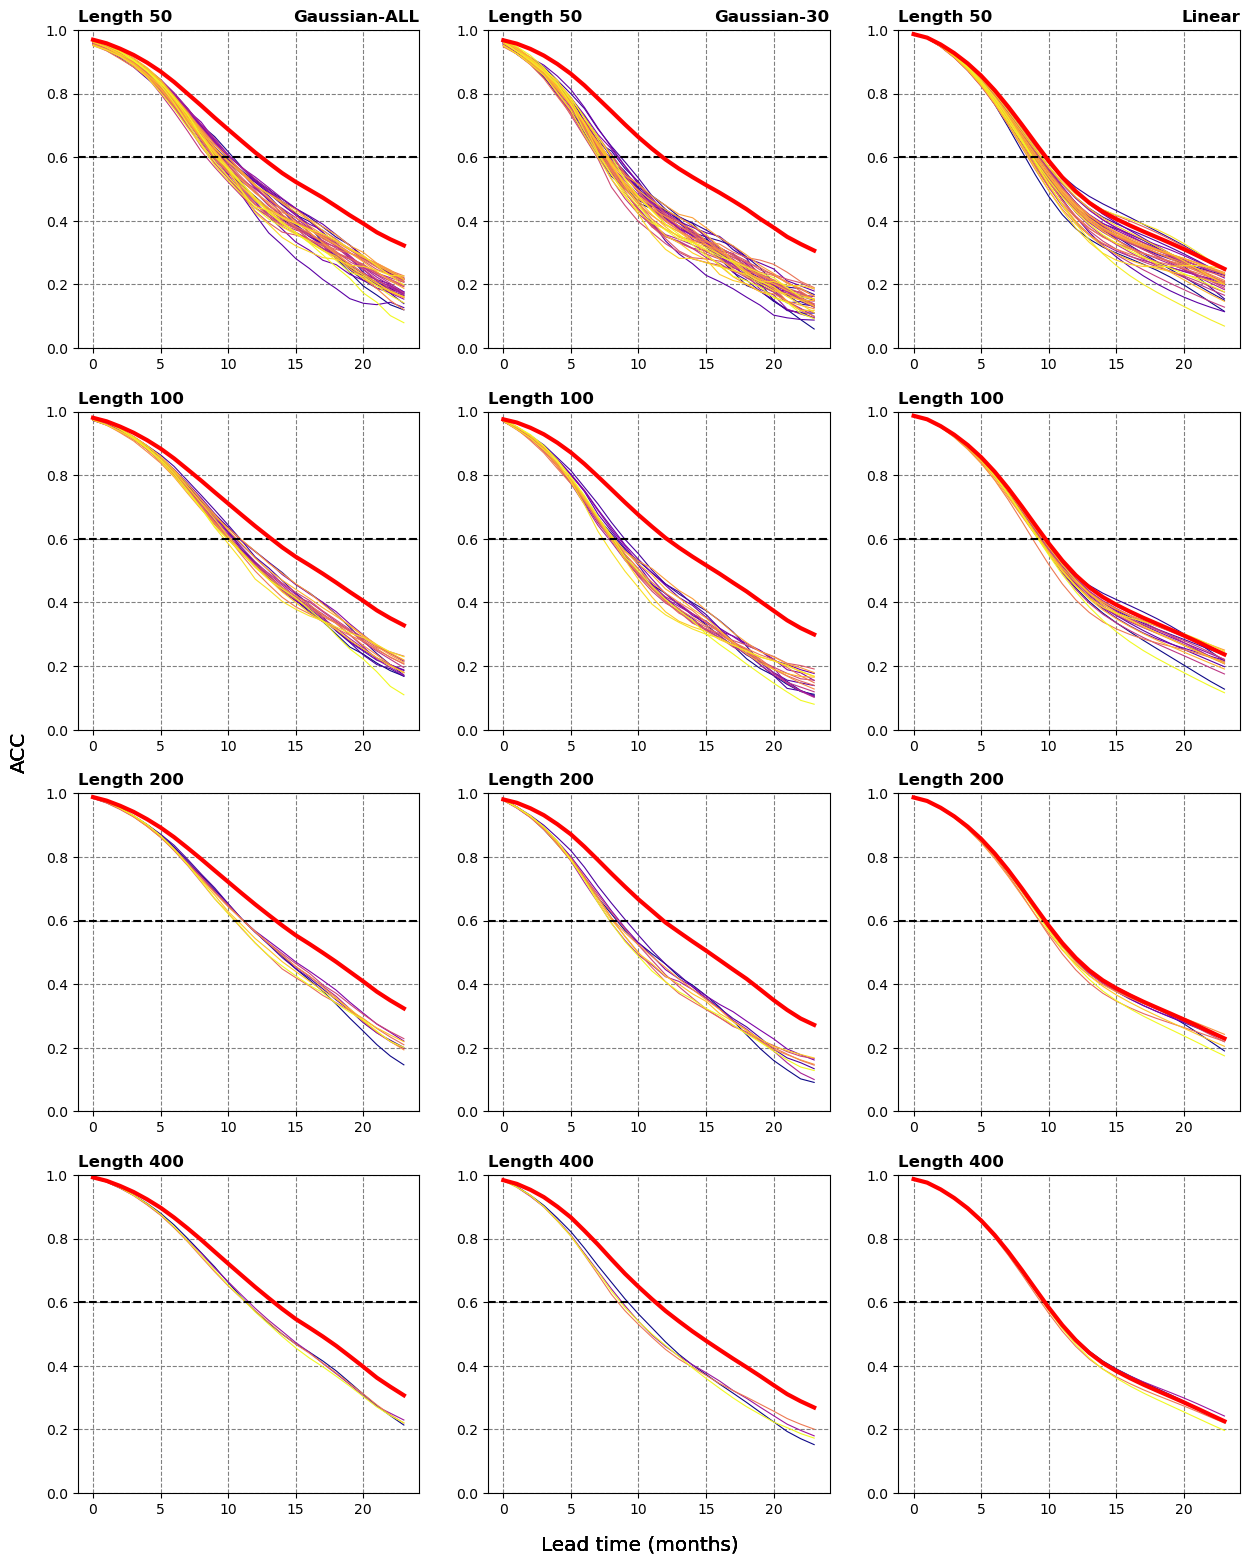

In [45]:
#EXTENDED
columns = 3
rows = 4

fig, axs = plt.subplots(rows, columns,figsize=(15,19))


##################################################################
#############          GAUSS ALL             ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'GaussALL_ind_{lenght}']
    mean_av= globals()[f'GaussALL_mean_{lenght}']

    cmap = cm.get_cmap('plasma', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    

    xval=range(0,24)
    
    for i in range(mean_ind.shape[1]):  
        
        val=mean_ind[:,i]
        axs[j,0].plot(xval,val, color= color_list[i], lw=0.8)

    axs[j,0].axhline(0.6, linestyle='--',color='black')
    #axs[j,0].set_xlabel('Time (months)')
    #axs[j,0].set_ylabel('Correlation')
    axs[j,0].set_ylim([0,1.0])
    if j==0:
        axs[j,0].set_title(f'Gaussian-ALL',loc='right',**flabel)
    axs[j,0].set_title(f'Length {lenght}',loc='Left',**flabel)
    axs[j,0].plot(xval, mean_av, color='red', lw=3, label='Average forecast')
    axs[j,0].yaxis.grid(color='gray', linestyle='dashed')
    axs[j,0].xaxis.grid(color='gray', linestyle='dashed')



##################################################################
#############          GAUSS 30             ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'Gauss30_ind_{lenght}']
    mean_av= globals()[f'Gauss30_mean_{lenght}']

    cmap = cm.get_cmap('plasma', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    

    xval=range(0,24)
    
    for i in range(mean_ind.shape[1]):  
        
        val=mean_ind[:,i]
        axs[j,1].plot(xval,val, color= color_list[i], lw=0.8)

    axs[j,1].axhline(0.6, linestyle='--',color='black')
    #axs[j,1].set_xlabel('Time (months)')
    #axs[j,1].set_ylabel('Correlation')
    axs[j,1].set_ylim([0,1.0])
    if j==0:
        axs[j,1].set_title(f'Gaussian-30',loc='right',**flabel)
    axs[j,1].set_title(f'Length {lenght}',loc='Left',**flabel)
    axs[j,1].plot(xval, mean_av, color='red', lw=3, label='Average forecast')
    axs[j,1].yaxis.grid(color='gray', linestyle='dashed')
    axs[j,1].xaxis.grid(color='gray', linestyle='dashed')


##################################################################
#############            POLY              ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'Poly_ind_{lenght}']
    mean_av= globals()[f'Poly_mean_{lenght}']

    cmap = cm.get_cmap('plasma', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    

    xval=range(0,24)
    
    for i in range(mean_ind.shape[1]):  
        
        val=mean_ind[:,i]
        axs[j,2].plot(xval,val, color= color_list[i], lw=0.8)

    axs[j,2].axhline(0.6, linestyle='--',color='black')
    #axs[j,2].set_xlabel('Time (months)')
    #axs[j,2].set_ylabel('Correlation')
    axs[j,2].set_ylim([0,1.0])
    if j==0:
        axs[j,2].set_title(f'Linear',loc='right',**flabel)
    axs[j,2].set_title(f'Length {lenght}',loc='Left',**flabel)
    axs[j,2].plot(xval, mean_av, color='red', lw=3, label='Average forecast')
    axs[j,2].yaxis.grid(color='gray', linestyle='dashed')
    axs[j,2].xaxis.grid(color='gray', linestyle='dashed')
    fig.text(0.5, 0.08, 'Lead time (months)', ha='center',fontsize='x-large')
    fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')



#plt.suptitle(f'Koopman Spectra',fontsize=14)   
#plt.savefig('Fig 4.pdf', orientation='landscape',  format='pdf')
#plt.savefig('Fig 4.jpg', orientation='landscape',  format='jpg')
plt.show() 

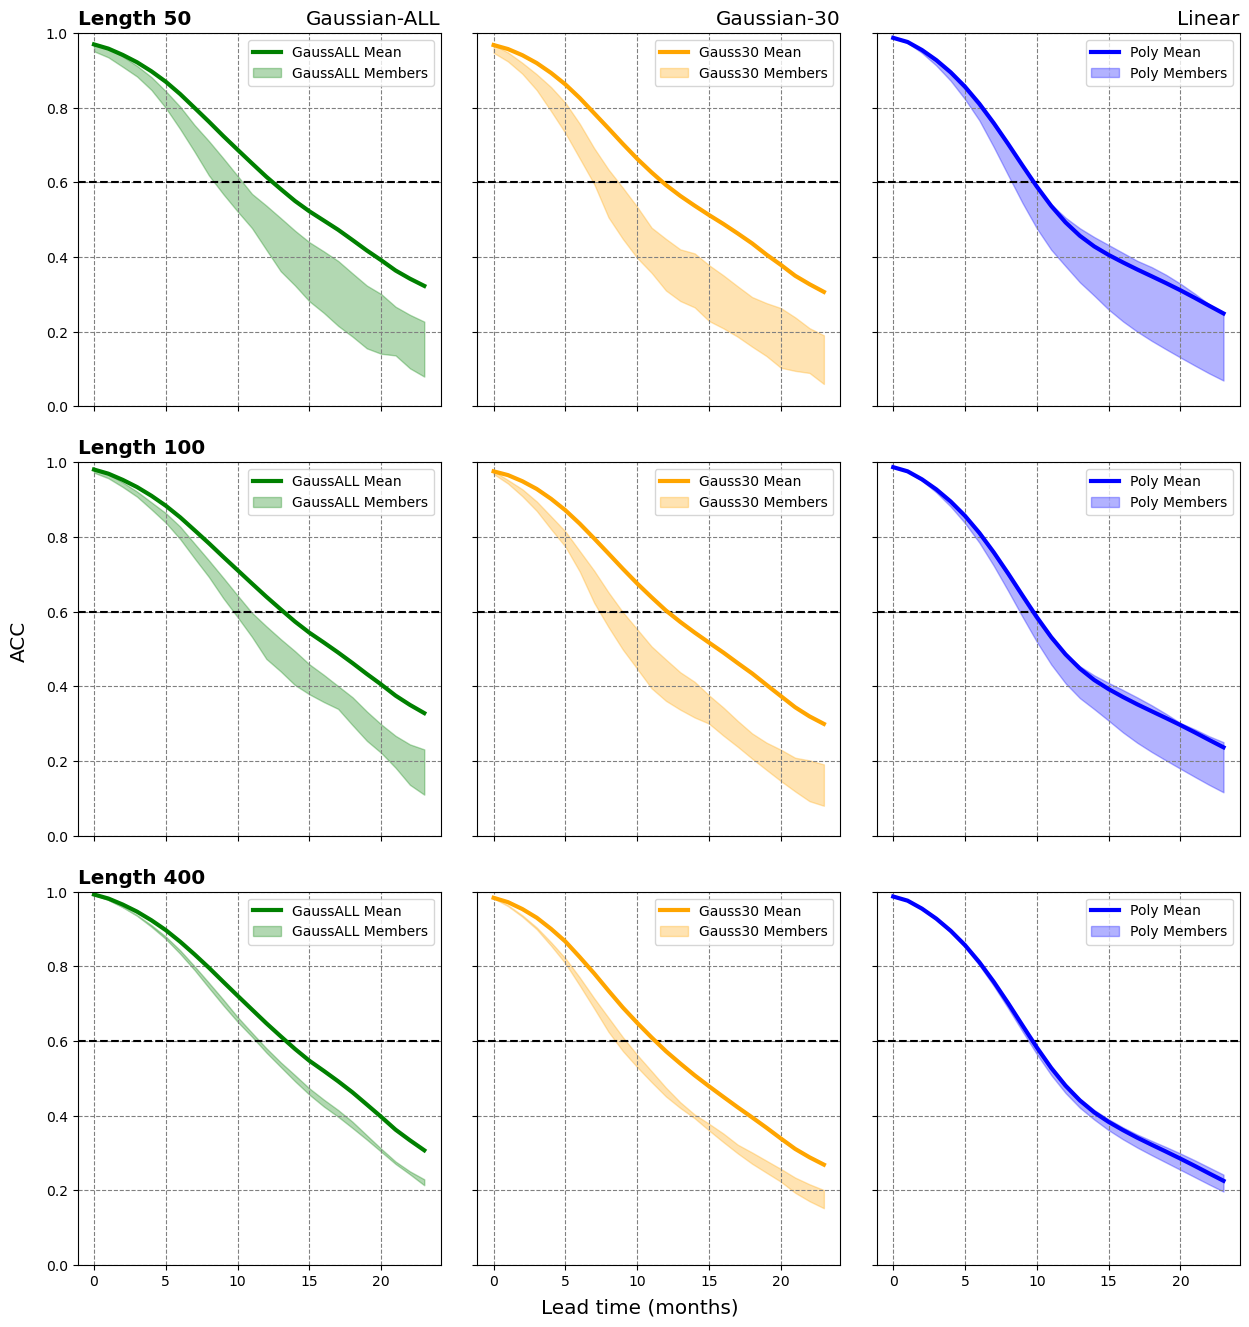

In [54]:
# REDUCED
columns = 3
rows = 3

lengths=['50', '100', '400']
methods=['GaussALL', 'Gauss30', 'Poly']
method_labels = ['Gaussian-ALL', 'Gaussian-30', 'Linear']

from pylab import *

fig, axs = plt.subplots(rows, columns, figsize=(15,16), sharey=True, sharex=True)

colors = ['green', 'orange', 'blue']

for j in range(len(lengths)):
    length = lengths[j]
    
    for k, method in enumerate(methods):
        mean_ind = globals()[f'{method}_ind_{length}']
        mean_av = globals()[f'{method}_mean_{length}']
        
        y_min = np.min(mean_ind, axis=1)
        y_max = np.max(mean_ind, axis=1)
        
        xval = range(0,24)
        
        axs[j, k].axhline(0.6, linestyle='--', color='black')
        axs[j, k].set_ylim([0,1.0])
        axs[j, k].plot(xval, mean_av, color=colors[k], lw=3, label=f'{method} Mean')
        axs[j, k].fill_between(xval, y_min, y_max, color=colors[k], alpha=0.3, label=f'{method} Members')
        axs[j, k].yaxis.grid(color='gray', linestyle='dashed')
        axs[j, k].xaxis.grid(color='gray', linestyle='dashed')
        axs[j, k].legend(loc='upper right')
        
        # Add left-aligned titles for lengths in the first column
        if k == 0:
            axs[j, k].set_title(f'Length {length}', loc='left', fontsize='x-large', fontweight='bold')
        
        # Add right-aligned titles for methods in the first row
        if j == 0:
            axs[j, k].set_title(f'{method_labels[k]}', loc='right', fontsize='x-large')

fig.text(0.5, 0.08, 'Lead time (months)', ha='center', fontsize='x-large')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical', fontsize='x-large')

plt.subplots_adjust(wspace=0.1, hspace=0.15)
plt.savefig('Fig 4_Extended.pdf', orientation='landscape', format='pdf')
plt.savefig('Fig 4_Extended.jpg', orientation='landscape', format='jpg')
plt.show()


# Old Fig 5

In [61]:
Poly_mean=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

In [62]:
Poly_ind=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [63]:
RMSE_Poly_mean=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_RMSE_POLY_100.npy')
RMSE_Gauss30_mean=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_RMSE_GAUSS30_100.npy')
RMSE_GaussALL_mean=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_RMSE_GAUSSALL_100.npy')

In [64]:
RMSE_Poly_ind=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_RMSE_POLY_100.npy')
RMSE_Gauss30_ind=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_RMSE_GAUSS30_100.npy')
RMSE_GaussALL_ind=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_RMSE_GAUSSALL_100.npy')

In [65]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

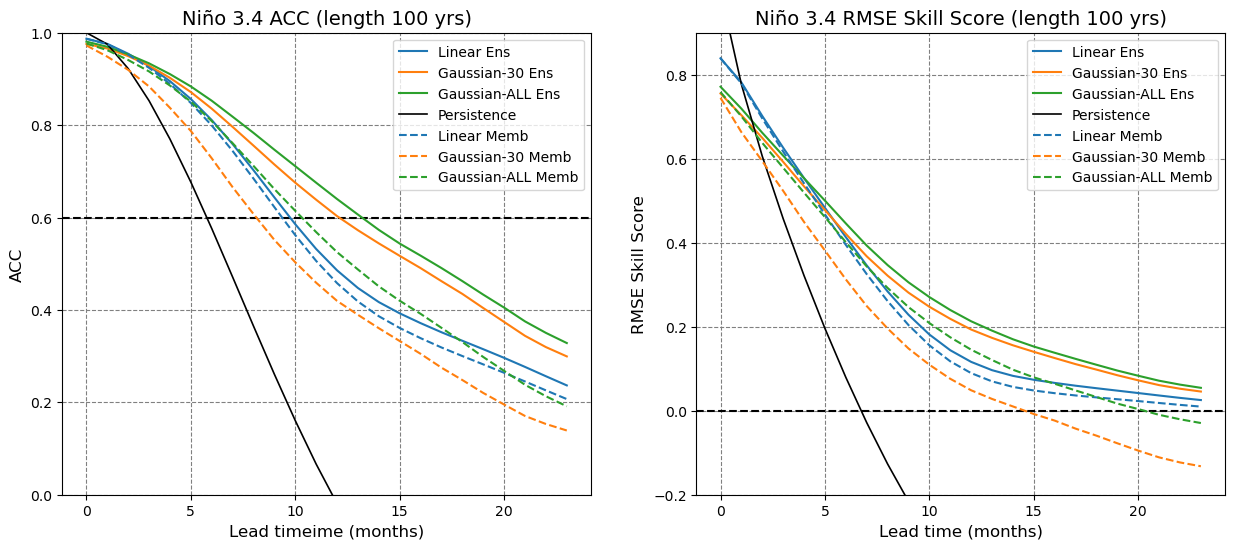

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

xval=range(0,24)

##################################################################
#############            ACC               ######################
##################################################################


ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Lead timeime (months)',fontsize=12)
ax[0].set_ylabel('ACC',fontsize=12)
ax[0].set_ylim([0,1.0])
ax[0].set_title('',loc='left')

ax[0].plot(xval, Poly_mean, lw=1.5, label='Linear Ens')
ax[0].plot(xval, Gauss30_mean, lw=1.5, label='Gaussian-30 Ens')
ax[0].plot(xval, GaussALL_mean, lw=1.5, label='Gaussian-ALL Ens')

ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

ax[0].set_prop_cycle(None)

ax[0].plot(xval, np.mean(Poly_ind, axis=1), linestyle='dashed', lw=1.5,  label='Linear Memb')
ax[0].plot(xval, np.mean(Gauss30_ind, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-30 Memb')
ax[0].plot(xval, np.mean(GaussALL_ind, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-ALL Memb')

bigtitle = 'Niño 3.4 ACC (length 100 yrs)' 
ax[0].set_title(bigtitle,fontsize=14)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')

ax[0].legend(loc='upper right')

##################################################################
#############            RMSE               ######################
##################################################################

ax[1].axhline(0, linestyle='--',color='black')
ax[1].set_xlabel('Lead time (months)',fontsize=12)
ax[1].set_ylabel('RMSE Skill Score',fontsize=12)
ax[1].set_ylim([-0.2,0.9])
ax[1].set_title('',loc='left')

ax[1].plot(xval, RMSE_Poly_mean, lw=1.5, label='Linear Ens')
ax[1].plot(xval, RMSE_Gauss30_mean, lw=1.5, label='Gaussian-30 Ens')
ax[1].plot(xval, RMSE_GaussALL_mean, lw=1.5, label='Gaussian-ALL Ens')
ax[1].plot(xval, RMSE_PERS, lw=1.2, label='Persistence', color='black')

ax[1].set_prop_cycle(None)

ax[1].plot(xval, np.mean(RMSE_Poly_ind, axis=1), linestyle='dashed', lw=1.5,  label='Linear Memb')
ax[1].plot(xval, np.mean(RMSE_Gauss30_ind, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-30 Memb')
ax[1].plot(xval, np.mean(RMSE_GaussALL_ind, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-ALL Memb')

bigtitle = 'Niño 3.4 RMSE Skill Score (length 100 yrs)' 
ax[1].set_title(bigtitle,fontsize=14)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')

ax[1].legend(loc='upper right')

#plt.suptitle('',fontsize='xx-large')
plt.savefig('Fig 5.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 5.jpg', orientation='landscape',  format='jpg')
plt.show() 

# Old Fig 6

In [61]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [62]:
Poly_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_1000.npy')
Gauss30_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_1000.npy')
GaussALL_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_1000.npy')

Poly_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_1000.npy')
Gauss30_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_1000.npy')
GaussALL_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_1000.npy')

In [63]:
Poly_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_400.npy')
Gauss30_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_400.npy')
GaussALL_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_400.npy')

Poly_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_400.npy')
Gauss30_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_400.npy')
GaussALL_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_400.npy')

In [64]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [65]:
Poly_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [66]:
Poly_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

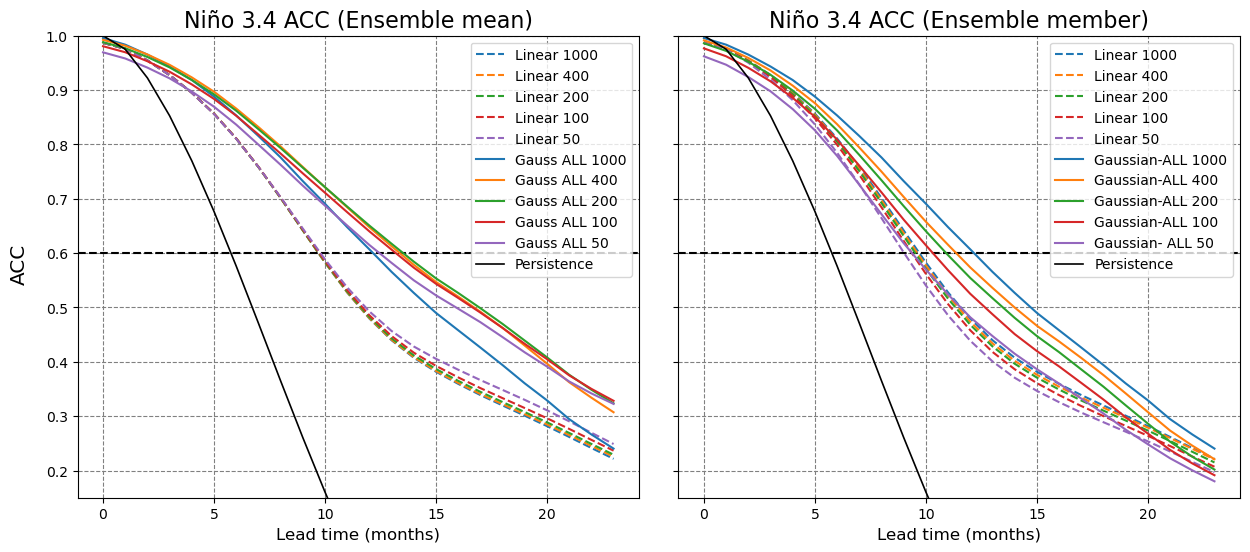

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6),sharex=True, sharey=True)


##################################################################
#############          ENS. MEAN             ######################
##################################################################

xval=range(0,24)

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Lead time (months)',fontsize=12)
ax[0].set_ylim([0.15,1])
ax[0].set_title('',loc='left')

ax[0].plot(xval, Poly_mean_1000, lw=1.5, label='Linear 1000', linestyle='dashed')
ax[0].plot(xval, Poly_mean_400, lw=1.5, label='Linear 400', linestyle='dashed')
ax[0].plot(xval, Poly_mean_200, lw=1.5, label='Linear 200', linestyle='dashed')
ax[0].plot(xval, Poly_mean_100, lw=1.5, label='Linear 100', linestyle='dashed')
ax[0].plot(xval, Poly_mean_50, lw=1.5, label='Linear 50', linestyle='dashed')

ax[0].set_prop_cycle(None)

ax[0].plot(xval, GaussALL_mean_1000, lw=1.5, label='Gauss ALL 1000')
ax[0].plot(xval, GaussALL_mean_400, lw=1.5, label='Gauss ALL 400')
ax[0].plot(xval, GaussALL_mean_200, lw=1.5, label='Gauss ALL 200')
ax[0].plot(xval, GaussALL_mean_100, lw=1.5, label='Gauss ALL 100')
ax[0].plot(xval, GaussALL_mean_50, lw=1.5, label='Gauss ALL 50')

ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
bigtitle = 'Niño 3.4 ACC (Ensemble mean)' 
ax[0].set_title(bigtitle,fontsize=16)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')

ax[0].legend(loc='upper right')


##################################################################
#############          ENS. MEMBER             ######################
##################################################################

xval=range(0,24)

ax[1].axhline(0.6, linestyle='--',color='black')
ax[1].set_xlabel('Lead time (months)',fontsize=12)
ax[1].set_ylim([0.15,1])
ax[1].set_title('',loc='left')

ax[1].plot(xval,  np.mean(Poly_ind_1000, axis=1), lw=1.5, label='Linear 1000', linestyle='dashed')
ax[1].plot(xval,  np.mean(Poly_ind_400, axis=1), lw=1.5, label='Linear 400', linestyle='dashed')
ax[1].plot(xval,  np.mean(Poly_ind_200, axis=1), lw=1.5, label='Linear 200', linestyle='dashed')
ax[1].plot(xval,  np.mean(Poly_ind_100, axis=1), lw=1.5, label='Linear 100', linestyle='dashed')
ax[1].plot(xval,  np.mean(Poly_ind_50, axis=1), lw=1.5, label='Linear 50', linestyle='dashed')

ax[1].set_prop_cycle(None)

ax[1].plot(xval,  np.mean(GaussALL_ind_1000, axis=1), lw=1.5, label='Gaussian-ALL 1000')
ax[1].plot(xval,  np.mean(GaussALL_ind_400, axis=1), lw=1.5, label='Gaussian-ALL 400')
ax[1].plot(xval,  np.mean(GaussALL_ind_200, axis=1), lw=1.5, label='Gaussian-ALL 200')
ax[1].plot(xval,  np.mean(GaussALL_ind_100, axis=1), lw=1.5, label='Gaussian-ALL 100')
ax[1].plot(xval,  np.mean(GaussALL_ind_50, axis=1), lw=1.5, label='Gaussian- ALL 50')

ax[1].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')


bigtitle = 'Niño 3.4 ACC (Ensemble member)' 
ax[1].set_title(bigtitle,fontsize=16)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.07)

ax[1].legend(loc='upper right')

plt.savefig('Fig 6.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 6.jpg', orientation='landscape',  format='jpg')
plt.show() 

# Fig 4

In [30]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [31]:
RMSE_Poly_mean=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_RMSE_POLY_200.npy')
RMSE_Gauss30_mean=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_RMSE_GAUSS30_200.npy')
RMSE_GaussALL_mean=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_RMSE_GAUSSALL_200.npy')

In [32]:
RMSE_Poly_ind=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_RMSE_POLY_200.npy')
RMSE_Gauss30_ind=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_RMSE_GAUSS30_200.npy')
RMSE_GaussALL_ind=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_RMSE_GAUSSALL_200.npy')

In [33]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [34]:
from pylab import *

In [35]:
flabel = {'fontsize':12,'fontweight':'normal'}   #,'fontfamily':'Futura'
ftitle = {'fontsize':14,'fontweight':'normal'}   #,'fontfamily':'Futura',

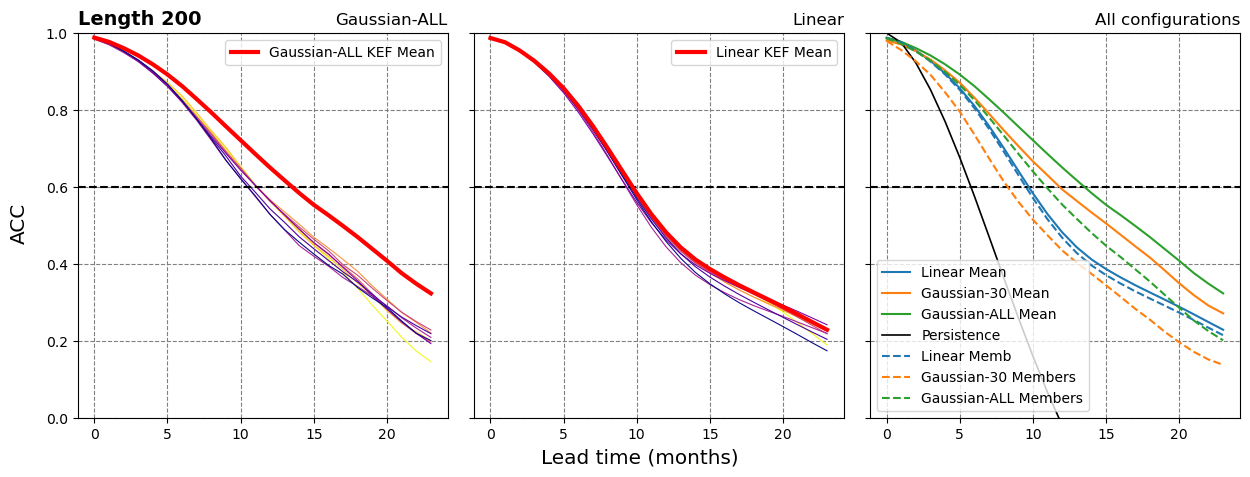

In [40]:
#REDUCED
columns = 3
rows = 1

lenghts=['200']
from pylab import *

fig, axs = plt.subplots(rows, columns,figsize=(15,5),sharey=True,sharex=True)


##################################################################
#############          GAUSS ALL             ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'GaussALL_ind_{lenght}']
    mean_av= globals()[f'GaussALL_mean_{lenght}']

    j=0

    cmap = cm.get_cmap('plasma_r', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    

    xval=range(0,24)
    
    for i in range(mean_ind.shape[1]):  
        
        val=mean_ind[:,i]
        axs[j].plot(xval,val, color= color_list[i], lw=0.8)

    axs[j].axhline(0.6, linestyle='--',color='black')
    axs[j].set_ylim([0,1.0])
    if j==0:
        axs[j].set_title(f'Gaussian-ALL',loc='right',**flabel)
    axs[j].set_title(f'Length {lenght}',loc='Left',**{'fontsize':14,'fontweight':'bold'})
    axs[j].plot(xval, mean_av, color='red', lw=3, label='Gaussian-ALL KEF Mean')
    axs[j].yaxis.grid(color='gray', linestyle='dashed')
    axs[j].xaxis.grid(color='gray', linestyle='dashed')
    axs[j].legend(loc='upper right')


##################################################################
#############            POLY              ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'Poly_ind_{lenght}']
    mean_av= globals()[f'Poly_mean_{lenght}']

    cmap = cm.get_cmap('plasma_r', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    j=1

    xval=range(0,24)
    
    for i in range(mean_ind.shape[1]):  
        
        val=mean_ind[:,i]
        axs[j].plot(xval,val, color= color_list[i], lw=0.8)

    axs[j].axhline(0.6, linestyle='--',color='black')
    axs[j].set_ylim([0,1.0])
    if j==1:
        axs[j].set_title(f'Linear',loc='right',**flabel)
    #axs[j].set_title(f'Length {lenght}',loc='Left',**flabel)
    axs[j].plot(xval, mean_av, color='red', lw=3, label='Linear KEF Mean')
    axs[j].yaxis.grid(color='gray', linestyle='dashed')
    axs[j].xaxis.grid(color='gray', linestyle='dashed')
    axs[j].legend(loc='upper right')

##################################################################
#############            ACC              ######################
##################################################################

axs[2].axhline(0.6, linestyle='--',color='black')
axs[2].set_xlabel('',fontsize=12)
axs[2].set_ylabel('',fontsize=12)
axs[2].set_ylim([0,1.0])
axs[2].set_title('All configurations',loc='right')

axs[2].plot(xval, Poly_mean, lw=1.5, label='Linear Mean')
axs[2].plot(xval, Gauss30_mean, lw=1.5, label='Gaussian-30 Mean')
axs[2].plot(xval, GaussALL_mean, lw=1.5, label='Gaussian-ALL Mean')

axs[2].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

axs[2].set_prop_cycle(None)

axs[2].plot(xval, np.mean(Poly_ind, axis=1), linestyle='dashed', lw=1.5,  label='Linear Memb')
axs[2].plot(xval, np.mean(Gauss30_ind, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-30 Members')
axs[2].plot(xval, np.mean(GaussALL_ind, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-ALL Members')

bigtitle = '' 
axs[2].set_title(bigtitle,fontsize=14)
axs[2].yaxis.grid(color='gray', linestyle='dashed')
axs[2].xaxis.grid(color='gray', linestyle='dashed')

axs[2].legend(loc='lower left')



fig.text(0.5, 0.02, 'Lead time (months)', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.07, hspace=0.15)
plt.savefig('Fig 4.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 4.jpg', orientation='landscape',  format='jpg')
plt.show() 

In [36]:
Poly_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

Poly_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_400.npy')
GaussALL_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_400.npy')

Poly_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
GaussALL_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

Poly_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
GaussALL_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

Poly_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_1000.npy')
GaussALL_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_1000.npy')

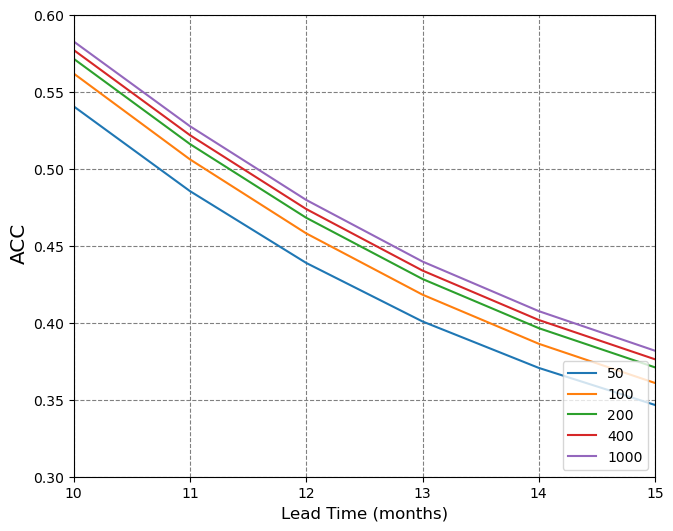

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7.5,6),sharex=False, sharey=False)

xval=range(0,24)

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
ax.set_xlabel('Lead Time (months)',fontsize=12)
ax.set_title('',loc='left')

ax.plot(xval, np.mean(Poly_ind_50, axis=1), label='50')
ax.plot(xval, np.mean(Poly_ind_100, axis=1), label='100')
ax.plot(xval, np.mean(Poly_ind_200, axis=1), label='200')
ax.plot(xval, np.mean(Poly_ind_400, axis=1), label='400')
ax.plot(xval, np.mean(Poly_ind_1000, axis=1), label='1000')


ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

ax.legend(loc='upper right')


bigtitle = '' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.04, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')

ax.set_xlim(10, 15)  # Set the x-axis limit from 0 to 23
ax.set_ylim(0.3, 0.6)   # Set the y-axis limit from 0 to 1


ax.legend(loc='lower right')

plt.show() 

In [52]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_200.npy')
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_400.npy')
GaussALL_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_400.npy')

Poly_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_100.npy')
GaussALL_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_50.npy')
GaussALL_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_1000.npy')
GaussALL_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_1000.npy')

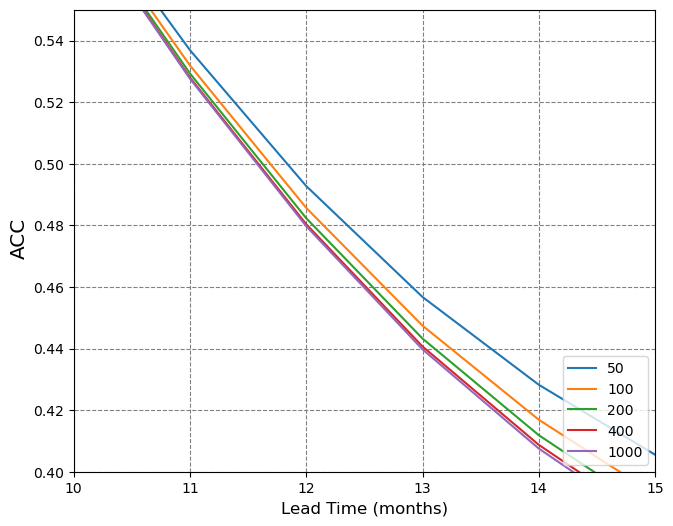

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7.5,6),sharex=False, sharey=False)

xval=range(0,24)

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
ax.set_xlabel('Lead Time (months)',fontsize=12)
ax.set_title('',loc='left')

ax.plot(xval, Poly_mean_50, label='50')
ax.plot(xval, Poly_mean_100, label='100')
ax.plot(xval, Poly_mean_200, label='200')
ax.plot(xval, Poly_mean_400, label='400')
ax.plot(xval, Poly_mean_1000, label='1000')


ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')

ax.legend(loc='upper right')


bigtitle = '' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.04, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')

ax.set_xlim(10, 15)  # Set the x-axis limit from 0 to 23
ax.set_ylim(0.4, 0.55)   # Set the y-axis limit from 0 to 1


ax.legend(loc='lower right')

plt.show() 

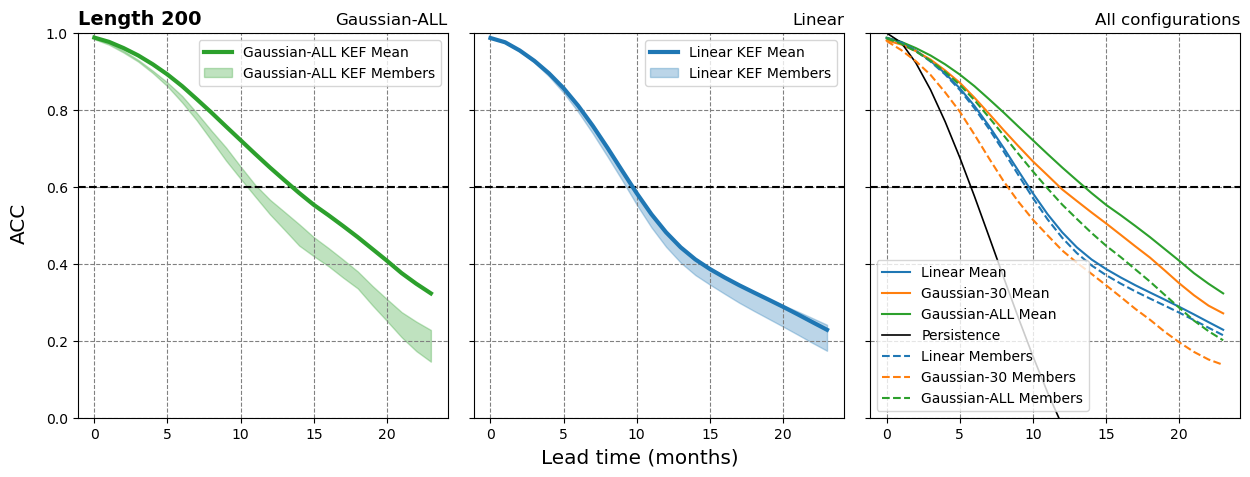

In [67]:
#REDUCED
columns = 3
rows = 1

lenghts=['200']
from pylab import *

fig, axs = plt.subplots(rows, columns,figsize=(15,5),sharey=True,sharex=True)


##################################################################
#############          GAUSS ALL             ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'GaussALL_ind_{lenght}']
    mean_av= globals()[f'GaussALL_mean_{lenght}']

    # Calculate the minimum and maximum y-values for each x-value
    y_min=np.min(mean_ind, axis=1)
    y_max = np.max(mean_ind, axis=1)

    j=0

    cmap = cm.get_cmap('plasma_r', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    

    xval=range(0,24)
    
    axs[j].axhline(0.6, linestyle='--',color='black')
    axs[j].set_ylim([0,1.0])
    if j==0:
        axs[j].set_title(f'Gaussian-ALL',loc='right',**flabel)
    axs[j].set_title(f'Length {lenght}',loc='Left',**{'fontsize':14,'fontweight':'bold'})
    axs[j].plot(xval, mean_av, color='#2ca02c', lw=3, label='Gaussian-ALL KEF Mean')
    
    # Plot the shadowed area that encloses all lines
    axs[j].fill_between(xval, y_min, y_max, color='#2ca02c', alpha=0.3, label='Gaussian-ALL KEF Members')

    axs[j].yaxis.grid(color='gray', linestyle='dashed')
    axs[j].xaxis.grid(color='gray', linestyle='dashed')
    axs[j].legend(loc='upper right')


##################################################################
#############            POLY              ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'Poly_ind_{lenght}']
    mean_av= globals()[f'Poly_mean_{lenght}']

    # Calculate the minimum and maximum y-values for each x-value
    y_min=np.min(mean_ind, axis=1)
    y_max = np.max(mean_ind, axis=1)

    cmap = cm.get_cmap('plasma_r', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    j=1

    xval=range(0,24)
    
    axs[j].axhline(0.6, linestyle='--',color='black')
    axs[j].set_ylim([0,1.0])
    if j==1:
        axs[j].set_title(f'Linear',loc='right',**flabel)
    #axs[j].set_title(f'Length {lenght}',loc='Left',**flabel)
    axs[j].plot(xval, mean_av, color='#1f77b4', lw=3, label='Linear KEF Mean')
    
    # Plot the shadowed area that encloses all lines
    axs[j].fill_between(xval, y_min, y_max, color='#1f77b4', alpha=0.3, label='Linear KEF Members')

    axs[j].yaxis.grid(color='gray', linestyle='dashed')
    axs[j].xaxis.grid(color='gray', linestyle='dashed')
    axs[j].legend(loc='upper right')

##################################################################
#############            ACC              ######################
##################################################################

axs[2].axhline(0.6, linestyle='--',color='black')
axs[2].set_xlabel('',fontsize=12)
axs[2].set_ylabel('',fontsize=12)
axs[2].set_ylim([0,1.0])
axs[2].set_title('All configurations',loc='right')

axs[2].plot(xval, Poly_mean, lw=1.5, label='Linear Mean')
axs[2].plot(xval, Gauss30_mean, lw=1.5, label='Gaussian-30 Mean')
axs[2].plot(xval, GaussALL_mean, lw=1.5, label='Gaussian-ALL Mean')

axs[2].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')

axs[2].set_prop_cycle(None)

axs[2].plot(xval, np.mean(Poly_ind, axis=1), linestyle='dashed', lw=1.5,  label='Linear Members')
axs[2].plot(xval, np.mean(Gauss30_ind, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-30 Members')
axs[2].plot(xval, np.mean(GaussALL_ind, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-ALL Members')

bigtitle = '' 
axs[2].set_title(bigtitle,fontsize=14)
axs[2].yaxis.grid(color='gray', linestyle='dashed')
axs[2].xaxis.grid(color='gray', linestyle='dashed')

axs[2].legend(loc='lower left')



fig.text(0.5, 0.02, 'Lead time (months)', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.07, hspace=0.15)
plt.savefig('Fig 4.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 4.jpg', orientation='landscape',  format='jpg')
plt.show() 

In [39]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_RMSE_POLY_200.npy')
Gauss30_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_RMSE_GAUSS30_200.npy')
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_RMSE_GAUSSALL_200.npy')

Poly_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_RMSE_POLY_200.npy')
Gauss30_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_RMSE_GAUSS30_200.npy')
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_RMSE_GAUSSALL_200.npy')

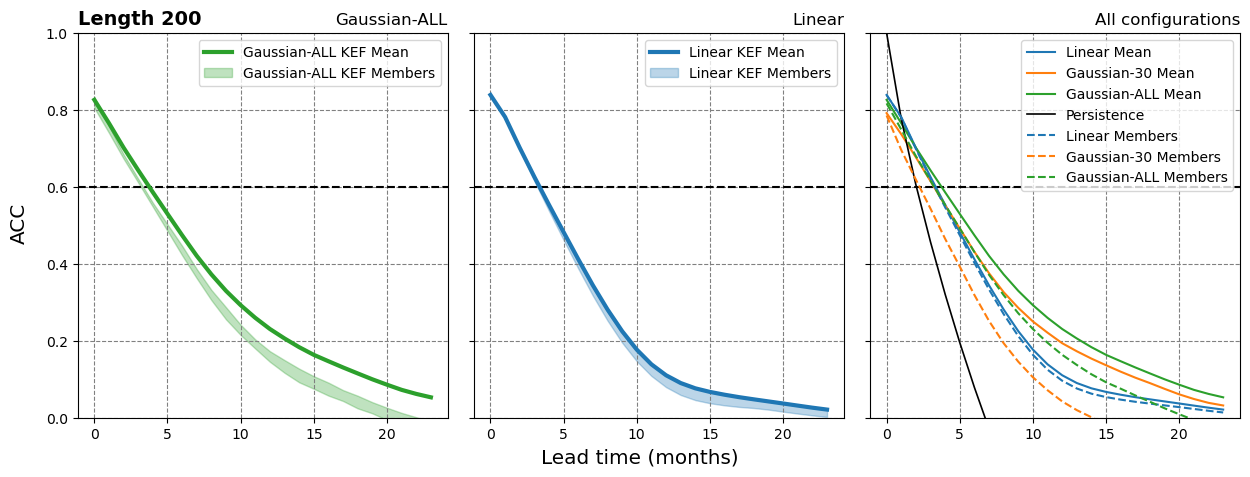

In [47]:
#EXTENDED RMSE
columns = 3
rows = 1

lenghts=['200']
from pylab import *

fig, axs = plt.subplots(rows, columns,figsize=(15,5),sharey=True,sharex=True)


##################################################################
#############          GAUSS ALL             ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'GaussALL_ind_{lenght}']
    mean_av= globals()[f'GaussALL_mean_{lenght}']

    # Calculate the minimum and maximum y-values for each x-value
    y_min=np.min(mean_ind, axis=1)
    y_max = np.max(mean_ind, axis=1)

    j=0

    cmap = cm.get_cmap('plasma_r', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    

    xval=range(0,24)
    
    axs[j].axhline(0.6, linestyle='--',color='black')
    axs[j].set_ylim([0,1.0])
    if j==0:
        axs[j].set_title(f'Gaussian-ALL',loc='right',**flabel)
    axs[j].set_title(f'Length {lenght}',loc='Left',**{'fontsize':14,'fontweight':'bold'})
    axs[j].plot(xval, mean_av, color='#2ca02c', lw=3, label='Gaussian-ALL KEF Mean')
    
    # Plot the shadowed area that encloses all lines
    axs[j].fill_between(xval, y_min, y_max, color='#2ca02c', alpha=0.3, label='Gaussian-ALL KEF Members')

    axs[j].yaxis.grid(color='gray', linestyle='dashed')
    axs[j].xaxis.grid(color='gray', linestyle='dashed')
    axs[j].legend(loc='upper right')


##################################################################
#############            POLY              ######################
##################################################################

for j in range(len(lenghts)):
    lenght=lenghts[j]

    mean_ind= globals()[f'Poly_ind_{lenght}']
    mean_av= globals()[f'Poly_mean_{lenght}']

    # Calculate the minimum and maximum y-values for each x-value
    y_min=np.min(mean_ind, axis=1)
    y_max = np.max(mean_ind, axis=1)

    cmap = cm.get_cmap('plasma_r', mean_ind.shape[1])
    color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

    j=1

    xval=range(0,24)
    
    axs[j].axhline(0.6, linestyle='--',color='black')
    axs[j].set_ylim([0,1.0])
    if j==1:
        axs[j].set_title(f'Linear',loc='right',**flabel)
    #axs[j].set_title(f'Length {lenght}',loc='Left',**flabel)
    axs[j].plot(xval, mean_av, color='#1f77b4', lw=3, label='Linear KEF Mean')
    
    # Plot the shadowed area that encloses all lines
    axs[j].fill_between(xval, y_min, y_max, color='#1f77b4', alpha=0.3, label='Linear KEF Members')

    axs[j].yaxis.grid(color='gray', linestyle='dashed')
    axs[j].xaxis.grid(color='gray', linestyle='dashed')
    axs[j].legend(loc='upper right')

##################################################################
#############            ACC              ######################
##################################################################

axs[2].axhline(0.6, linestyle='--',color='black')
axs[2].set_xlabel('',fontsize=12)
axs[2].set_ylabel('',fontsize=12)
axs[2].set_ylim([0,1.0])
axs[2].set_title('All configurations',loc='right')

axs[2].plot(xval, Poly_mean_200, lw=1.5, label='Linear Mean')
axs[2].plot(xval, Gauss30_mean_200, lw=1.5, label='Gaussian-30 Mean')
axs[2].plot(xval, GaussALL_mean_200, lw=1.5, label='Gaussian-ALL Mean')

axs[2].plot(xval, RMSE_PERS, lw=1.2, label='Persistence', color='black')

axs[2].set_prop_cycle(None)

axs[2].plot(xval, np.mean(Poly_ind_200, axis=1), linestyle='dashed', lw=1.5,  label='Linear Members')
axs[2].plot(xval, np.mean(Gauss30_ind_200, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-30 Members')
axs[2].plot(xval, np.mean(GaussALL_ind_200, axis=1), linestyle='dashed', lw=1.5, label='Gaussian-ALL Members')

bigtitle = '' 
axs[2].set_title(bigtitle,fontsize=14)
axs[2].yaxis.grid(color='gray', linestyle='dashed')
axs[2].xaxis.grid(color='gray', linestyle='dashed')

axs[2].legend(loc='upper right')



fig.text(0.5, 0.02, 'Lead time (months)', ha='center',fontsize='x-large')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')


plt.subplots_adjust(wspace=0.07, hspace=0.15)
plt.savefig('Fig 4_RMSE.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 4_RMSE.jpg', orientation='landscape',  format='jpg')
plt.show() 

# Fig 5

In [25]:
RMSE_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_RMSE.npy')
CORR_PERS=np.load('Forecasts 100/Skill metrics/PERSISTENCE_CORR.npy')

In [26]:
Poly_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_1000.npy')
Gauss30_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_1000.npy')
GaussALL_mean_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_1000.npy')

Poly_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_1000.npy')
Gauss30_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_1000.npy')
GaussALL_ind_1000=np.load('Forecasts 1000/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_1000.npy')

In [27]:
Poly_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_400.npy')
Gauss30_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_400.npy')
GaussALL_mean_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_400.npy')

Poly_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_400.npy')
Gauss30_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_400.npy')
GaussALL_ind_400=np.load('Forecasts 400/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_400.npy')

In [28]:
Poly_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_200.npy')
Gauss30_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_200.npy')
GaussALL_mean_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_200.npy')

Poly_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_200.npy')
Gauss30_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_200.npy')
GaussALL_ind_200=np.load('Forecasts 200/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_200.npy')

In [29]:
Poly_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_100.npy')
Gauss30_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_100.npy')
GaussALL_mean_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_100.npy')

Poly_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_100.npy')
Gauss30_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_100.npy')
GaussALL_ind_100=np.load('Forecasts 100/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_100.npy')

In [30]:
Poly_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_POLY_50.npy')
Gauss30_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSS30_50.npy')
GaussALL_mean_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEAN_CORR_GAUSSALL_50.npy')

Poly_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_POLY_50.npy')
Gauss30_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSS30_50.npy')
GaussALL_ind_50=np.load('Forecasts 50/Skill metrics/ENSEMBLE_MEMBERS_CORR_GAUSSALL_50.npy')

In [31]:
lead=12
acc_gauss_mean=np.zeros(5)
acc_gauss_mean[0]=GaussALL_mean_50[lead]
acc_gauss_mean[1]=GaussALL_mean_100[lead]
acc_gauss_mean[2]=GaussALL_mean_200[lead]
acc_gauss_mean[3]=GaussALL_mean_400[lead]
acc_gauss_mean[4]=GaussALL_mean_1000[lead]

acc_gauss_ind=np.zeros(5)
acc_gauss_ind[0]=np.mean(GaussALL_ind_50[lead])
acc_gauss_ind[1]=np.mean(GaussALL_ind_100[lead])
acc_gauss_ind[2]=np.mean(GaussALL_ind_200[lead])
acc_gauss_ind[3]=np.mean(GaussALL_ind_400[lead])
acc_gauss_ind[4]=np.mean(GaussALL_ind_1000[lead])

acc_gauss30_mean=np.zeros(5)
acc_gauss30_mean[0]=Gauss30_mean_50[lead]
acc_gauss30_mean[1]=Gauss30_mean_100[lead]
acc_gauss30_mean[2]=Gauss30_mean_200[lead]
acc_gauss30_mean[3]=Gauss30_mean_400[lead]
acc_gauss30_mean[4]=Gauss30_mean_1000[lead]

acc_gauss30_ind=np.zeros(5)
acc_gauss30_ind[0]=np.mean(Gauss30_ind_50[lead])
acc_gauss30_ind[1]=np.mean(Gauss30_ind_100[lead])
acc_gauss30_ind[2]=np.mean(Gauss30_ind_200[lead])
acc_gauss30_ind[3]=np.mean(Gauss30_ind_400[lead])
acc_gauss30_ind[4]=np.mean(Gauss30_ind_1000[lead])

acc_poly_mean=np.zeros(5)
acc_poly_mean[0]=Poly_mean_50[lead]
acc_poly_mean[1]=Poly_mean_100[lead]
acc_poly_mean[2]=Poly_mean_200[lead]
acc_poly_mean[3]=Poly_mean_400[lead]
acc_poly_mean[4]=Poly_mean_1000[lead]

acc_poly_ind=np.zeros(5)
acc_poly_ind[0]=np.mean(Poly_ind_50[lead])
acc_poly_ind[1]=np.mean(Poly_ind_100[lead])
acc_poly_ind[2]=np.mean(Poly_ind_200[lead])
acc_poly_ind[3]=np.mean(Poly_ind_400[lead])
acc_poly_ind[4]=np.mean(Poly_ind_1000[lead])

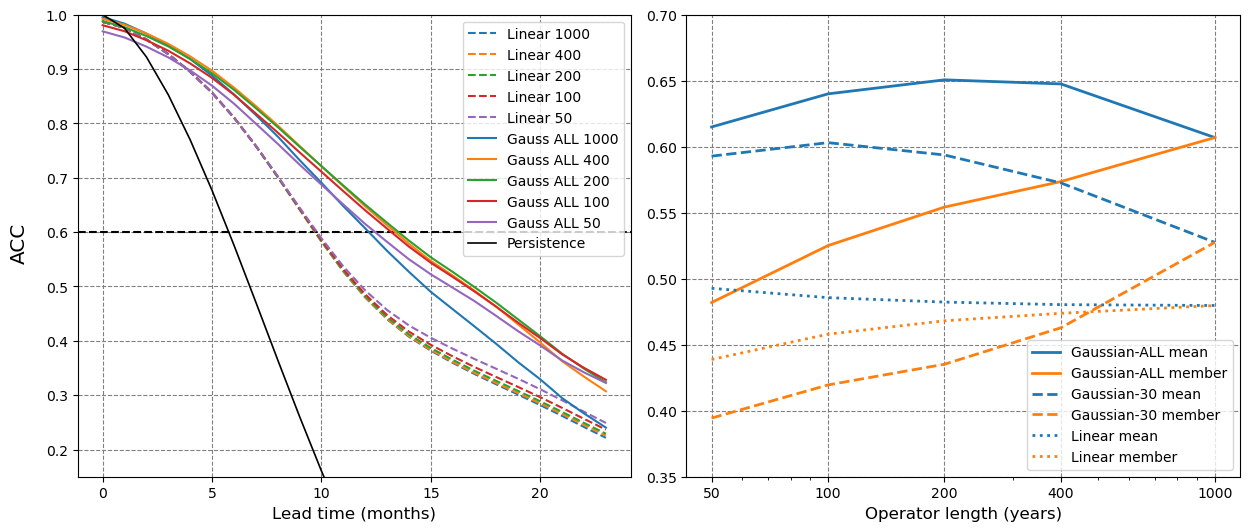

In [160]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6),sharex=False, sharey=False)


##################################################################
#############          ENS. MEAN             ######################
##################################################################

xval=range(0,24)

ax[0].axhline(0.6, linestyle='--',color='black')
ax[0].set_xlabel('Lead time (months)',fontsize=12)
ax[0].set_ylim([0.15,1])
ax[0].set_title('',loc='left')

ax[0].plot(xval, Poly_mean_1000, lw=1.5, label='Linear 1000', linestyle='dashed')
ax[0].plot(xval, Poly_mean_400, lw=1.5, label='Linear 400', linestyle='dashed')
ax[0].plot(xval, Poly_mean_200, lw=1.5, label='Linear 200', linestyle='dashed')
ax[0].plot(xval, Poly_mean_100, lw=1.5, label='Linear 100', linestyle='dashed')
ax[0].plot(xval, Poly_mean_50, lw=1.5, label='Linear 50', linestyle='dashed')

ax[0].set_prop_cycle(None)

ax[0].plot(xval, GaussALL_mean_1000, lw=1.5, label='Gauss ALL 1000')
ax[0].plot(xval, GaussALL_mean_400, lw=1.5, label='Gauss ALL 400')
ax[0].plot(xval, GaussALL_mean_200, lw=1.5, label='Gauss ALL 200')
ax[0].plot(xval, GaussALL_mean_100, lw=1.5, label='Gauss ALL 100')
ax[0].plot(xval, GaussALL_mean_50, lw=1.5, label='Gauss ALL 50')

ax[0].plot(xval, CORR_PERS, lw=1.2, label='Persistence', color='black')
bigtitle = '' 
ax[0].set_title(bigtitle,fontsize=16)
ax[0].yaxis.grid(color='gray', linestyle='dashed')
ax[0].xaxis.grid(color='gray', linestyle='dashed')

ax[0].legend(loc='upper right')


##################################################################
#############          NEW VISION             ######################
##################################################################

xval=[50,100,200,400,1000]

#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
ax[1].set_xlabel('Operator length (years)',fontsize=12)
ax[1].set_ylim([0.35,0.7])
ax[1].set_title('',loc='left')

ax[1].plot(xval, acc_gauss_mean, lw=2, label='Gaussian-ALL mean')
ax[1].plot(xval, acc_gauss_ind, lw=2, label='Gaussian-ALL member')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, acc_gauss30_mean, lw=2, label='Gaussian-30 mean', linestyle='dashed')
ax[1].plot(xval, acc_gauss30_ind, lw=2, label='Gaussian-30 member', linestyle='dashed')
ax[1].set_prop_cycle(None)
ax[1].plot(xval, acc_poly_mean, lw=2, label='Linear mean', linestyle='dotted')
ax[1].plot(xval, acc_poly_ind, lw=2, label='Linear member', linestyle='dotted')


bigtitle = f'Niño 3.4 ACC ({lead} months)' 
ax[1].set_title(bigtitle,fontsize=16)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
plt.xscale("log")
plt.xticks(ticks=xval, labels=['50','100','200','400','1000'])

ax[1].legend(loc='upper right')


bigtitle = '' 
ax[1].set_title(bigtitle,fontsize=16)
ax[1].yaxis.grid(color='gray', linestyle='dashed')
ax[1].xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.1)

ax[1].legend(loc='lower right')

plt.savefig('Fig 5.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 5.jpg', orientation='landscape',  format='jpg')
plt.show() 

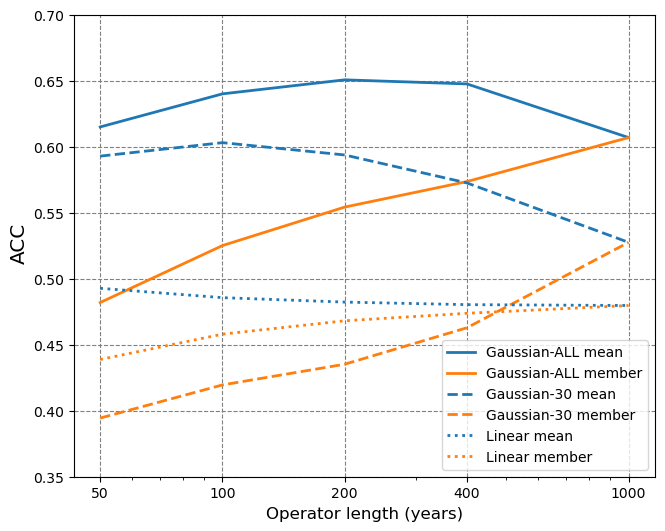

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(7.5,6),sharex=False, sharey=False)


##################################################################
#############          NEW VISION             ######################
##################################################################

xval=[50,100,200,400,1000]


#ax.axhline(corr, linestyle='--',color='black', label='Persistence')
ax.set_xlabel('Operator length (years)',fontsize=12)
ax.set_ylim([0.35,0.7])
ax.set_title('',loc='left')

ax.plot(xval, acc_gauss_mean, lw=2, label='Gaussian-ALL mean')
ax.plot(xval, acc_gauss_ind, lw=2, label='Gaussian-ALL member')
ax.set_prop_cycle(None)
ax.plot(xval, acc_gauss30_mean, lw=2, label='Gaussian-30 mean', linestyle='dashed')
ax.plot(xval, acc_gauss30_ind, lw=2, label='Gaussian-30 member', linestyle='dashed')
ax.set_prop_cycle(None)
ax.plot(xval, acc_poly_mean, lw=2, label='Linear mean', linestyle='dotted')
ax.plot(xval, acc_poly_ind, lw=2, label='Linear member', linestyle='dotted')


bigtitle = f'Niño 3.4 ACC ({lead} months)' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.xscale("log")
plt.xticks(ticks=xval, labels=['50','100','200','400','1000'])

ax.legend(loc='upper right')


bigtitle = '' 
ax.set_title(bigtitle,fontsize=16)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
fig.text(0.04, 0.5, 'ACC', va='center', rotation='vertical',fontsize='x-large')
plt.subplots_adjust(wspace=0.1)

ax.legend(loc='lower right')

plt.savefig('Fig 5.1.pdf', orientation='landscape',  format='pdf')
plt.savefig('Fig 5.1.jpg', orientation='landscape',  format='jpg')
plt.show() 

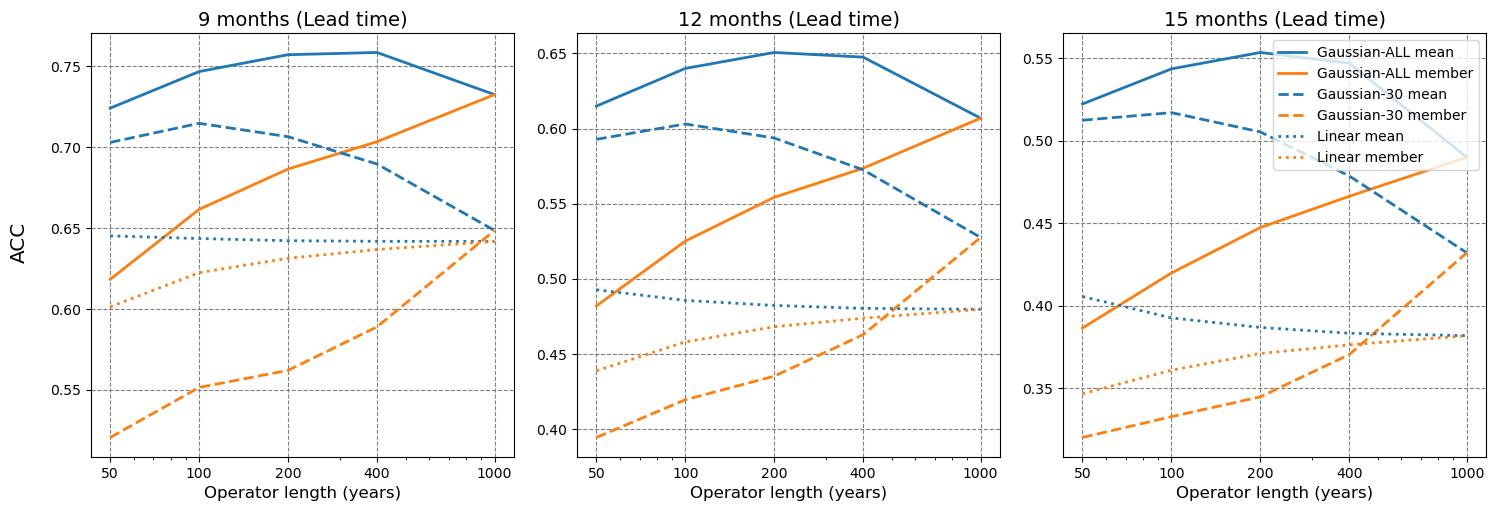

In [33]:
# REDUCED
columns = 3
rows = 1

xval = [50, 100, 200, 400, 1000]

from pylab import *

fig, (ax1, ax2, ax3) = plt.subplots(rows, columns, figsize=(18, 5.5), sharey=False, sharex=True)

# Data for Panel 1
lead=9
acc_gauss_mean=np.zeros(5)
acc_gauss_mean[0]=GaussALL_mean_50[lead]
acc_gauss_mean[1]=GaussALL_mean_100[lead]
acc_gauss_mean[2]=GaussALL_mean_200[lead]
acc_gauss_mean[3]=GaussALL_mean_400[lead]
acc_gauss_mean[4]=GaussALL_mean_1000[lead]

acc_gauss_ind=np.zeros(5)
acc_gauss_ind[0]=np.mean(GaussALL_ind_50[lead])
acc_gauss_ind[1]=np.mean(GaussALL_ind_100[lead])
acc_gauss_ind[2]=np.mean(GaussALL_ind_200[lead])
acc_gauss_ind[3]=np.mean(GaussALL_ind_400[lead])
acc_gauss_ind[4]=np.mean(GaussALL_ind_1000[lead])

acc_gauss30_mean=np.zeros(5)
acc_gauss30_mean[0]=Gauss30_mean_50[lead]
acc_gauss30_mean[1]=Gauss30_mean_100[lead]
acc_gauss30_mean[2]=Gauss30_mean_200[lead]
acc_gauss30_mean[3]=Gauss30_mean_400[lead]
acc_gauss30_mean[4]=Gauss30_mean_1000[lead]

acc_gauss30_ind=np.zeros(5)
acc_gauss30_ind[0]=np.mean(Gauss30_ind_50[lead])
acc_gauss30_ind[1]=np.mean(Gauss30_ind_100[lead])
acc_gauss30_ind[2]=np.mean(Gauss30_ind_200[lead])
acc_gauss30_ind[3]=np.mean(Gauss30_ind_400[lead])
acc_gauss30_ind[4]=np.mean(Gauss30_ind_1000[lead])

acc_poly_mean=np.zeros(5)
acc_poly_mean[0]=Poly_mean_50[lead]
acc_poly_mean[1]=Poly_mean_100[lead]
acc_poly_mean[2]=Poly_mean_200[lead]
acc_poly_mean[3]=Poly_mean_400[lead]
acc_poly_mean[4]=Poly_mean_1000[lead]

acc_poly_ind=np.zeros(5)
acc_poly_ind[0]=np.mean(Poly_ind_50[lead])
acc_poly_ind[1]=np.mean(Poly_ind_100[lead])
acc_poly_ind[2]=np.mean(Poly_ind_200[lead])
acc_poly_ind[3]=np.mean(Poly_ind_400[lead])
acc_poly_ind[4]=np.mean(Poly_ind_1000[lead])

ax1.set_xlabel('Operator length (years)', fontsize=12)
ax1.set_title('9 months (Lead time)', fontsize=14)
ax1.plot(xval, acc_gauss_mean, lw=2, label='Gaussian-ALL mean')
ax1.plot(xval, acc_gauss_ind, lw=2, label='Gaussian-ALL member')
ax1.set_prop_cycle(None)
ax1.plot(xval, acc_gauss30_mean, lw=2, label='Gaussian-30 mean', linestyle='dashed')
ax1.plot(xval, acc_gauss30_ind, lw=2, label='Gaussian-30 member', linestyle='dashed')
ax1.set_prop_cycle(None)
ax1.plot(xval, acc_poly_mean, lw=2, label='Linear mean', linestyle='dotted')
ax1.plot(xval, acc_poly_ind, lw=2, label='Linear member', linestyle='dotted')
ax1.yaxis.grid(color='gray', linestyle='dashed')
ax1.xaxis.grid(color='gray', linestyle='dashed')

ax1.set_xscale("log")
ax1.set_xticks(ticks=xval, labels=['50','100','200','400','1000'])

# Data for Panel 2 (modify later as needed)
lead=12
acc_gauss_mean=np.zeros(5)
acc_gauss_mean[0]=GaussALL_mean_50[lead]
acc_gauss_mean[1]=GaussALL_mean_100[lead]
acc_gauss_mean[2]=GaussALL_mean_200[lead]
acc_gauss_mean[3]=GaussALL_mean_400[lead]
acc_gauss_mean[4]=GaussALL_mean_1000[lead]

acc_gauss_ind=np.zeros(5)
acc_gauss_ind[0]=np.mean(GaussALL_ind_50[lead])
acc_gauss_ind[1]=np.mean(GaussALL_ind_100[lead])
acc_gauss_ind[2]=np.mean(GaussALL_ind_200[lead])
acc_gauss_ind[3]=np.mean(GaussALL_ind_400[lead])
acc_gauss_ind[4]=np.mean(GaussALL_ind_1000[lead])

acc_gauss30_mean=np.zeros(5)
acc_gauss30_mean[0]=Gauss30_mean_50[lead]
acc_gauss30_mean[1]=Gauss30_mean_100[lead]
acc_gauss30_mean[2]=Gauss30_mean_200[lead]
acc_gauss30_mean[3]=Gauss30_mean_400[lead]
acc_gauss30_mean[4]=Gauss30_mean_1000[lead]

acc_gauss30_ind=np.zeros(5)
acc_gauss30_ind[0]=np.mean(Gauss30_ind_50[lead])
acc_gauss30_ind[1]=np.mean(Gauss30_ind_100[lead])
acc_gauss30_ind[2]=np.mean(Gauss30_ind_200[lead])
acc_gauss30_ind[3]=np.mean(Gauss30_ind_400[lead])
acc_gauss30_ind[4]=np.mean(Gauss30_ind_1000[lead])

acc_poly_mean=np.zeros(5)
acc_poly_mean[0]=Poly_mean_50[lead]
acc_poly_mean[1]=Poly_mean_100[lead]
acc_poly_mean[2]=Poly_mean_200[lead]
acc_poly_mean[3]=Poly_mean_400[lead]
acc_poly_mean[4]=Poly_mean_1000[lead]

acc_poly_ind=np.zeros(5)
acc_poly_ind[0]=np.mean(Poly_ind_50[lead])
acc_poly_ind[1]=np.mean(Poly_ind_100[lead])
acc_poly_ind[2]=np.mean(Poly_ind_200[lead])
acc_poly_ind[3]=np.mean(Poly_ind_400[lead])
acc_poly_ind[4]=np.mean(Poly_ind_1000[lead])

ax2.set_xlabel('Operator length (years)', fontsize=12)
ax2.set_title('12 months (Lead time)', fontsize=14)
ax2.plot(xval, acc_gauss_mean, lw=2, label='Gaussian-ALL mean')
ax2.plot(xval, acc_gauss_ind, lw=2, label='Gaussian-ALL member')
ax2.set_prop_cycle(None)
ax2.plot(xval, acc_gauss30_mean, lw=2, label='Gaussian-30 mean', linestyle='dashed')
ax2.plot(xval, acc_gauss30_ind, lw=2, label='Gaussian-30 member', linestyle='dashed')
ax2.set_prop_cycle(None)
ax2.plot(xval, acc_poly_mean, lw=2, label='Linear mean', linestyle='dotted')
ax2.plot(xval, acc_poly_ind, lw=2, label='Linear member', linestyle='dotted')
ax2.yaxis.grid(color='gray', linestyle='dashed')
ax2.xaxis.grid(color='gray', linestyle='dashed')

ax2.set_xscale("log")
ax2.set_xticks(ticks=xval, labels=['50','100','200','400','1000'])


# Data for Panel 3 (modify later as needed)
lead=15
acc_gauss_mean=np.zeros(5)
acc_gauss_mean[0]=GaussALL_mean_50[lead]
acc_gauss_mean[1]=GaussALL_mean_100[lead]
acc_gauss_mean[2]=GaussALL_mean_200[lead]
acc_gauss_mean[3]=GaussALL_mean_400[lead]
acc_gauss_mean[4]=GaussALL_mean_1000[lead]

acc_gauss_ind=np.zeros(5)
acc_gauss_ind[0]=np.mean(GaussALL_ind_50[lead])
acc_gauss_ind[1]=np.mean(GaussALL_ind_100[lead])
acc_gauss_ind[2]=np.mean(GaussALL_ind_200[lead])
acc_gauss_ind[3]=np.mean(GaussALL_ind_400[lead])
acc_gauss_ind[4]=np.mean(GaussALL_ind_1000[lead])

acc_gauss30_mean=np.zeros(5)
acc_gauss30_mean[0]=Gauss30_mean_50[lead]
acc_gauss30_mean[1]=Gauss30_mean_100[lead]
acc_gauss30_mean[2]=Gauss30_mean_200[lead]
acc_gauss30_mean[3]=Gauss30_mean_400[lead]
acc_gauss30_mean[4]=Gauss30_mean_1000[lead]

acc_gauss30_ind=np.zeros(5)
acc_gauss30_ind[0]=np.mean(Gauss30_ind_50[lead])
acc_gauss30_ind[1]=np.mean(Gauss30_ind_100[lead])
acc_gauss30_ind[2]=np.mean(Gauss30_ind_200[lead])
acc_gauss30_ind[3]=np.mean(Gauss30_ind_400[lead])
acc_gauss30_ind[4]=np.mean(Gauss30_ind_1000[lead])

acc_poly_mean=np.zeros(5)
acc_poly_mean[0]=Poly_mean_50[lead]
acc_poly_mean[1]=Poly_mean_100[lead]
acc_poly_mean[2]=Poly_mean_200[lead]
acc_poly_mean[3]=Poly_mean_400[lead]
acc_poly_mean[4]=Poly_mean_1000[lead]

acc_poly_ind=np.zeros(5)
acc_poly_ind[0]=np.mean(Poly_ind_50[lead])
acc_poly_ind[1]=np.mean(Poly_ind_100[lead])
acc_poly_ind[2]=np.mean(Poly_ind_200[lead])
acc_poly_ind[3]=np.mean(Poly_ind_400[lead])
acc_poly_ind[4]=np.mean(Poly_ind_1000[lead])
ax3.set_xlabel('Operator length (years)', fontsize=12)
ax3.set_title('15 months (Lead time)', fontsize=14)
ax3.plot(xval, acc_gauss_mean, lw=2, label='Gaussian-ALL mean')
ax3.plot(xval, acc_gauss_ind, lw=2, label='Gaussian-ALL member')
ax3.set_prop_cycle(None)
ax3.plot(xval, acc_gauss30_mean, lw=2, label='Gaussian-30 mean', linestyle='dashed')
ax3.plot(xval, acc_gauss30_ind, lw=2, label='Gaussian-30 member', linestyle='dashed')
ax3.set_prop_cycle(None)
ax3.plot(xval, acc_poly_mean, lw=2, label='Linear mean', linestyle='dotted')
ax3.plot(xval, acc_poly_ind, lw=2, label='Linear member', linestyle='dotted')
ax3.yaxis.grid(color='gray', linestyle='dashed')
ax3.xaxis.grid(color='gray', linestyle='dashed')
ax3.legend(loc='upper right')

ax3.set_xscale("log")
ax3.set_xticks(ticks=xval, labels=['50','100','200','400','1000'])


fig.text(0.08, 0.5, 'ACC', va='center', rotation='vertical', fontsize='x-large')
plt.subplots_adjust(wspace=0.15)

plt.savefig('Fig 5_Extended.pdf', orientation='landscape', format='pdf')
plt.savefig('Fig 5_Extended.jpg', orientation='landscape', format='jpg')
plt.show()



# Seasonality

In [25]:
#GAUSS
corr_gauss=np.zeros((24,12))

In [29]:
#Select EOFs
udat_sst=EOFs[:,0:845]

In [30]:
## Compute observations NON truncated to PCs
Obs=X_tos.A.unstack()

In [31]:
### Load data

tot_for=np.zeros((20, 17, 1845, 24, 1176))

for n in range(len(periods)):
    tot_for[n,:,:,:,:]= np.load(f'Forecasts 200/ALLEOFs_forecast_p{n}.npy')

tot_for_union=np.empty((17, 1845, 24, 24000))
tot_for_union.fill(np.NaN)

for m in lead_times:
    for n in periods:
        tot_for_union[:,:,m, m + n*1200 : m + n*1200 +1176]=tot_for[n,:,:,m,:]

In [32]:
tot_for_union=tot_for_union[(0,2,4,6,8,10,12,14,16),:,:,:]

In [33]:
tot_for_union=np.mean(tot_for_union, axis=0)

In [34]:
tot_for_union.shape

(1845, 24, 24000)

In [42]:
for i in [21,22,23]:
    forecast=tot_for_union[:,i,:]

    for j in range (12):

        print('Lead ', i, ', Month ', j)

        Season_obs=X_tos.A[:,j+1::12]
        Xindex=Season_obs.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))
        
        season_for=forecast[:,j+1::12]
        ## Compute average forecast
        av_for_geo_array=udat_sst @ season_for[0:845,:]            
        av_for_geo = xr.full_like(X_tos.A[:,j+1::12],0)
        av_for_geo.data=av_for_geo_array.real
        For_index=av_for_geo.unstack().sel(lat=slice(-5,5),lon=slice(170,220)).mean(dim=('lat','lon'))

        #Correlation average forecast and observations
        corr_gauss[i,j]=np.corrcoef(Xindex[np.invert(np.isnan(For_index))],For_index[np.invert(np.isnan(For_index))])[0,1]
        

Lead  21 , Month  0
Lead  21 , Month  1
Lead  21 , Month  2
Lead  21 , Month  3
Lead  21 , Month  4
Lead  21 , Month  5
Lead  21 , Month  6
Lead  21 , Month  7
Lead  21 , Month  8
Lead  21 , Month  9
Lead  21 , Month  10
Lead  21 , Month  11
Lead  22 , Month  0
Lead  22 , Month  1
Lead  22 , Month  2
Lead  22 , Month  3
Lead  22 , Month  4
Lead  22 , Month  5
Lead  22 , Month  6
Lead  22 , Month  7
Lead  22 , Month  8
Lead  22 , Month  9
Lead  22 , Month  10
Lead  22 , Month  11
Lead  23 , Month  0
Lead  23 , Month  1
Lead  23 , Month  2
Lead  23 , Month  3
Lead  23 , Month  4
Lead  23 , Month  5
Lead  23 , Month  6
Lead  23 , Month  7
Lead  23 , Month  8
Lead  23 , Month  9
Lead  23 , Month  10
Lead  23 , Month  11


In [43]:
corr_gauss

array([[0.99142672, 0.9905424 , 0.98948495, 0.98929618, 0.98835885,
        0.98753329, 0.98654972, 0.98475102, 0.98455253, 0.9869475 ,
        0.98882764, 0.99044236],
       [0.98535553, 0.98106217, 0.9723961 , 0.97285827, 0.97730237,
        0.97285094, 0.97176818, 0.97255257, 0.97616766, 0.97965641,
        0.98145554, 0.98465635],
       [0.9768865 , 0.96767057, 0.95068429, 0.95016091, 0.95850456,
        0.9542748 , 0.94556168, 0.94995005, 0.96109534, 0.97114574,
        0.97435353, 0.97597336],
       [0.9684359 , 0.95583366, 0.92988103, 0.92427433, 0.93331656,
        0.92962449, 0.92004628, 0.92026318, 0.93857943, 0.95626372,
        0.9666419 , 0.96822544],
       [0.95915291, 0.9458772 , 0.9125719 , 0.8981381 , 0.9026898 ,
        0.89595072, 0.8861538 , 0.89009974, 0.90504139, 0.93067119,
        0.95004275, 0.95866796],
       [0.94734071, 0.93528043, 0.89971859, 0.87491949, 0.87104899,
        0.85599807, 0.84382795, 0.8546399 , 0.87575602, 0.89568902,
        0.92319711,

In [44]:
np.save('Other skill metrics/Seasonal_skill_Gauss_200.npy', corr_gauss)

### Plot 

In [25]:
gauss=np.load('Other skill metrics/Seasonal_skill_Gauss_200.npy')
gauss

array([[0.99142672, 0.9905424 , 0.98948495, 0.98929618, 0.98835885,
        0.98753329, 0.98654972, 0.98475102, 0.98455253, 0.9869475 ,
        0.98882764, 0.99044236],
       [0.98535553, 0.98106217, 0.9723961 , 0.97285827, 0.97730237,
        0.97285094, 0.97176818, 0.97255257, 0.97616766, 0.97965641,
        0.98145554, 0.98465635],
       [0.9768865 , 0.96767057, 0.95068429, 0.95016091, 0.95850456,
        0.9542748 , 0.94556168, 0.94995005, 0.96109534, 0.97114574,
        0.97435353, 0.97597336],
       [0.9684359 , 0.95583366, 0.92988103, 0.92427433, 0.93331656,
        0.92962449, 0.92004628, 0.92026318, 0.93857943, 0.95626372,
        0.9666419 , 0.96822544],
       [0.95915291, 0.9458772 , 0.9125719 , 0.8981381 , 0.9026898 ,
        0.89595072, 0.8861538 , 0.89009974, 0.90504139, 0.93067119,
        0.95004275, 0.95866796],
       [0.94734071, 0.93528043, 0.89971859, 0.87491949, 0.87104899,
        0.85599807, 0.84382795, 0.8546399 , 0.87575602, 0.89568902,
        0.92319711,

In [26]:
#POLY
poly=np.load('Other skill metrics/Seasonal_skill_Poly_200.npy')
poly

array([[0.99115241, 0.98927922, 0.98422247, 0.98514542, 0.98727893,
        0.98510675, 0.9852941 , 0.98665466, 0.9890618 , 0.98944474,
        0.98996553, 0.99096306],
       [0.98574786, 0.97990392, 0.96773387, 0.96673064, 0.97526462,
        0.97169711, 0.96821247, 0.97423739, 0.98294447, 0.98906112,
        0.98871255, 0.98670812],
       [0.97776872, 0.96443666, 0.94181711, 0.94007357, 0.94520917,
        0.94070277, 0.9347136 , 0.94647003, 0.96582734, 0.97925946,
        0.98471243, 0.98166864],
       [0.97194069, 0.95315841, 0.91807257, 0.90878809, 0.913208  ,
        0.89339311, 0.89071394, 0.90658693, 0.93644514, 0.96031402,
        0.97339022, 0.97566217],
       [0.96419658, 0.94473336, 0.89788169, 0.87547186, 0.87576858,
        0.84845273, 0.83025913, 0.85832903, 0.89553355, 0.92700767,
        0.95159738, 0.96257557],
       [0.94823208, 0.93464487, 0.88422838, 0.84575963, 0.82979334,
        0.79377467, 0.76978311, 0.79385194, 0.84892525, 0.88541322,
        0.91354636,

In [27]:
diff= gauss-poly

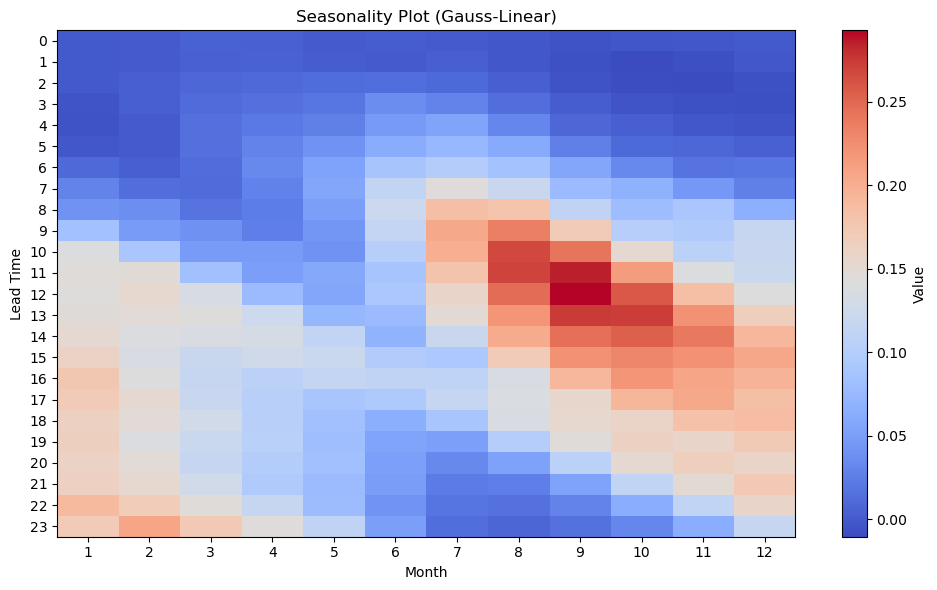

In [28]:
# Plot
plt.figure(figsize=(10, 6))
plt.imshow(diff, cmap='coolwarm', interpolation='nearest', aspect='auto')

# Add color bar
plt.colorbar(label='Value')

# Customize ticks and labels
plt.xticks(np.arange(12), [str(i+1) for i in range(12)])  # Months
plt.yticks(np.arange(24), [str(i) for i in range(24)])  # Lead times

plt.xlabel('Month')
plt.ylabel('Lead Time')

plt.title('Seasonality Plot (Gauss-Linear)')

plt.tight_layout()
plt.show()

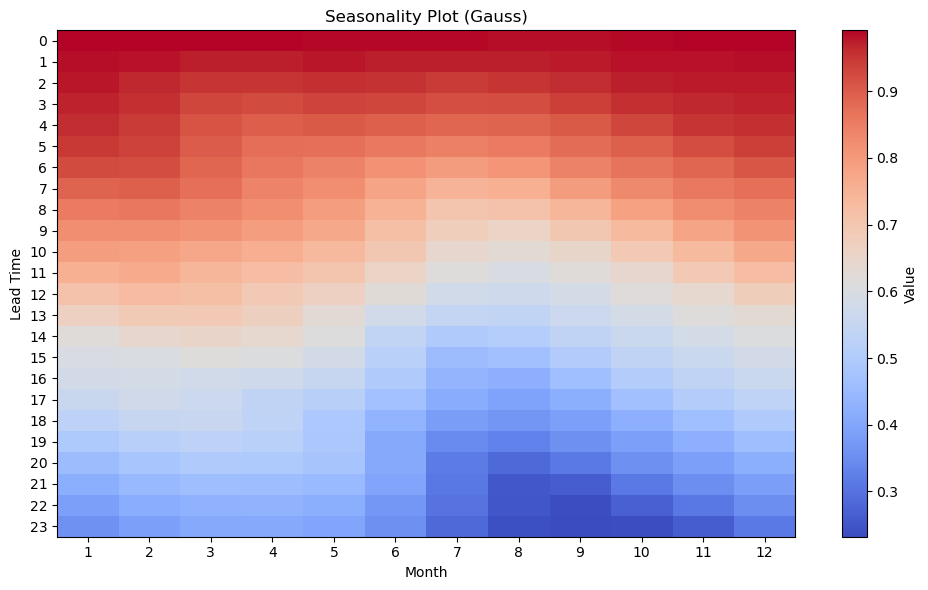

In [32]:
# Plot
plt.figure(figsize=(10, 6))
plt.imshow(gauss, cmap='coolwarm', interpolation='nearest', aspect='auto')

# Add color bar
plt.colorbar(label='Value')

# Customize ticks and labels
plt.xticks(np.arange(12), [str(i+1) for i in range(12)])  # Months
plt.yticks(np.arange(24), [str(i) for i in range(24)])  # Lead times

plt.xlabel('Month')
plt.ylabel('Lead Time')

plt.title('Seasonality Plot (Gauss)')

plt.tight_layout()
plt.show()

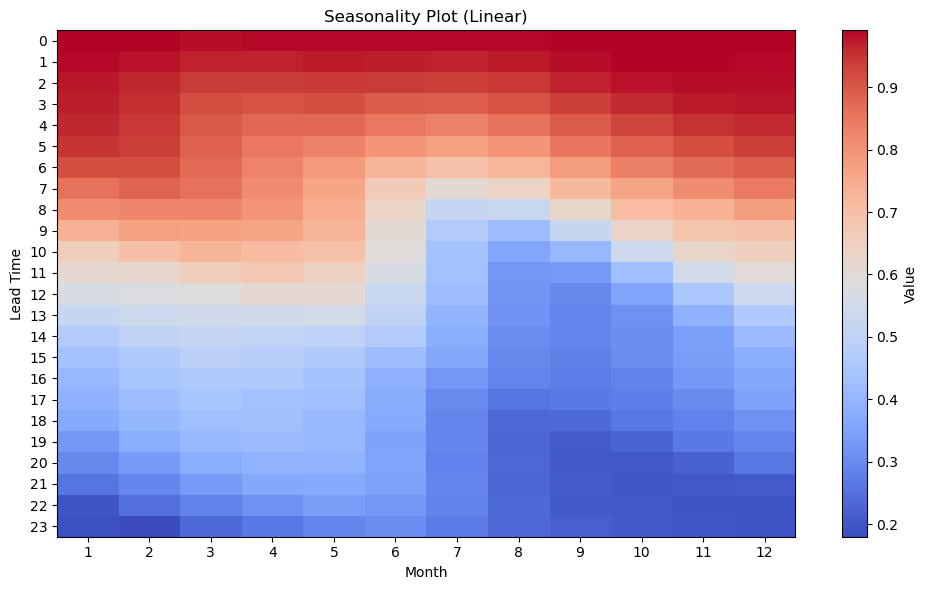

In [33]:
# Plot
plt.figure(figsize=(10, 6))
plt.imshow(poly, cmap='coolwarm', interpolation='nearest', aspect='auto')

# Add color bar
plt.colorbar(label='Value')

# Customize ticks and labels
plt.xticks(np.arange(12), [str(i+1) for i in range(12)])  # Months
plt.yticks(np.arange(24), [str(i) for i in range(24)])  # Lead times

plt.xlabel('Month')
plt.ylabel('Lead Time')

plt.title('Seasonality Plot (Linear)')

plt.tight_layout()
plt.show()